# Analysis of Popularity Bias Recommendation Results (Excluding MF)

This notebook analyzes the results generated by `Music_Recommendation.ipynb` and `Movie_Recommendation.ipynb`, **excluding data associated with the 'MF' algorithm**.
It loads the %ΔGAP and NDCG@10 metrics, along with their statistical significance tests, across different domains, evaluation strategies, user grouping methods, and algorithms.

**Objectives:**
1. Load and consolidate all results (excluding MF).
2. Generate a single structured CSV for external analysis (e.g., with LLMs).
3. Create insightful tables and visualizations comparing the metrics across various dimensions.
4. Draw conclusions based on the analysis, referencing the original research paper's focus.

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re # For parsing filenames

# --- Configuration ---
RESULTS_DIR = 'mitigated_results03/' # Directory where the recommendation notebooks saved results
CONSOLIDATED_CSV_PATH = os.path.join(RESULTS_DIR, 'consolidated_results.csv') # Updated filename
FIGURES_DIR = os.path.join(RESULTS_DIR, 'analysis_figures/') # Updated directory
os.makedirs(FIGURES_DIR, exist_ok=True)

# Define the dimensions we expect results for
DOMAINS = ['music', 'movie']
EVA_STRATEGIES = ['eva_two', 'eva_three']
# Pop three is only applicable for music, but we'll handle missing files
POP_NOTIONS = ['pop_one', 'pop_two', 'pop_three', 'pop_four'] 
# List algorithms used in both notebooks, EXCLUDING 'MF'
ALGORITHMS = ["MostPop", "UserKNN", "ItemKNN", "PMF", "NMF", "HPF"]
USER_GROUPS = ['low', 'med', 'high']
USER_GROUP_NAMES = {'low': 'Niche/Low', 'med': 'Diverse/Med', 'high': 'Blockbuster/High'}
TTEST_COMPARISONS = ['low-med', 'low-high', 'med-high']

# Plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

## 2. Data Loading (Excluding MF)

In [2]:
def load_results(results_dir, domains, eva_strategies, pop_notions, algorithms):
    """Loads all generated result CSV files into a nested dictionary, excluding 'MF'."""
    loaded_data = {domain: {} for domain in domains}
    
    file_patterns = {
        'ndcg': 'NDCGs_{domain}_{eva}_{pop}.csv',
        'ndcg_ttest': 'NDCG_ttests_{domain}_{eva}_{pop}.csv',
        'gap': 'PercentDeltaGAP_{domain}_{eva}_{pop}.csv',
        'gap_ttest': 'GAP_ttests_{domain}_{eva}_{pop}.csv'
    }

    for domain in domains:
        loaded_data[domain] = {eva: {} for eva in eva_strategies}
        for eva in eva_strategies:
            loaded_data[domain][eva] = {pop: {} for pop in pop_notions}
            for pop in pop_notions:
                # Skip pop_three for movie
                if domain == 'movie' and pop == 'pop_three':
                    continue
                    
                print(f"Loading: {domain}, {eva}, {pop}")
                data_loaded_for_combo = False
                for metric_type, pattern in file_patterns.items():
                    filename = pattern.format(domain=domain, eva=eva, pop=pop)
                    filepath = os.path.join(results_dir, filename)
                    try:
                        df = pd.read_csv(filepath, index_col=0)
                        # --- EXCLUDE MF HERE ---
                        df = df[df.index != 'MF'] 
                        # Ensure only expected algorithms (minus MF) are included
                        df = df[df.index.isin(algorithms)]
                        if not df.empty:
                             loaded_data[domain][eva][pop][metric_type] = df
                             data_loaded_for_combo = True
                        # else: print(f"  - Empty file (after MF exclusion): {filename}")
                    except FileNotFoundError:
                        print(f"  - File not found: {filename}")
                    except Exception as e:
                        print(f"  - Error loading {filename}: {e}")
                
                # If no data was loaded for this combo, remove the empty dict
                if not data_loaded_for_combo:
                     if pop in loaded_data[domain][eva]: # Check if key exists before deleting
                         del loaded_data[domain][eva][pop]
            # Clean up empty eva dicts
            if not loaded_data[domain][eva]:
                 if eva in loaded_data[domain]:
                     del loaded_data[domain][eva]
        # Clean up empty domain dicts
        if not loaded_data[domain]:
             if domain in loaded_data:
                 del loaded_data[domain]
             
    print("\nData loading complete (excluding MF).")
    return loaded_data

# Load the data (ALGORITHMS list already excludes MF)
all_results_data = load_results(RESULTS_DIR, DOMAINS, EVA_STRATEGIES, POP_NOTIONS, ALGORITHMS)

Loading: music, eva_two, pop_one
Loading: music, eva_two, pop_two
Loading: music, eva_two, pop_three
  - File not found: NDCGs_music_eva_two_pop_three.csv
  - File not found: NDCG_ttests_music_eva_two_pop_three.csv
  - File not found: PercentDeltaGAP_music_eva_two_pop_three.csv
  - File not found: GAP_ttests_music_eva_two_pop_three.csv
Loading: music, eva_two, pop_four
Loading: music, eva_three, pop_one
Loading: music, eva_three, pop_two
Loading: music, eva_three, pop_three
  - File not found: NDCGs_music_eva_three_pop_three.csv
  - File not found: NDCG_ttests_music_eva_three_pop_three.csv
  - File not found: PercentDeltaGAP_music_eva_three_pop_three.csv
  - File not found: GAP_ttests_music_eva_three_pop_three.csv
Loading: music, eva_three, pop_four
Loading: movie, eva_two, pop_one
Loading: movie, eva_two, pop_two
Loading: movie, eva_two, pop_four
Loading: movie, eva_three, pop_one
Loading: movie, eva_three, pop_two
Loading: movie, eva_three, pop_four

Data loading complete (excluding 

## 3. Consolidate Results into Single CSV (Excluding MF)

In [3]:
def create_consolidated_df(loaded_data):
    """Consolidates loaded results into a single long-format DataFrame."""
    records = []
    for domain, eva_data in loaded_data.items():
        for eva, pop_data in eva_data.items():
            for pop, metric_data in pop_data.items():
                # Process Metric Values (NDCG, GAP)
                for metric_key in ['ndcg', 'gap']:
                    if metric_key in metric_data:
                        df_metric = metric_data[metric_key]
                        # Melt DataFrame to long format
                        df_melted = df_metric.reset_index().melt(
                            id_vars='index', 
                            var_name='user_group', 
                            value_name='value'
                        )
                        df_melted.rename(columns={'index': 'algorithm'}, inplace=True)
                        df_melted['domain'] = domain
                        df_melted['evaluation_strategy'] = eva
                        df_melted['popularity_notion'] = pop
                        df_melted['metric_type'] = metric_key.upper() # e.g., 'NDCG', 'GAP'
                        # Add placeholder for t-test specific columns
                        df_melted['comparison_group'] = 'N/A'
                        df_melted['p_value'] = np.nan
                        records.extend(df_melted.to_dict('records'))
                
                # Process T-test Values
                for ttest_key in ['ndcg_ttest', 'gap_ttest']:
                    if ttest_key in metric_data:
                        df_ttest = metric_data[ttest_key]
                        df_melted = df_ttest.reset_index().melt(
                            id_vars='index',
                            var_name='comparison_group',
                            value_name='p_value'
                        )
                        df_melted.rename(columns={'index': 'algorithm'}, inplace=True)
                        df_melted['domain'] = domain
                        df_melted['evaluation_strategy'] = eva
                        df_melted['popularity_notion'] = pop
                        df_melted['metric_type'] = ttest_key.upper() # e.g., 'NDCG_TTEST', 'GAP_TTEST'
                        # Add placeholder for metric value columns
                        df_melted['user_group'] = 'N/A'
                        df_melted['value'] = np.nan 
                        records.extend(df_melted.to_dict('records'))
                        
    consolidated_df = pd.DataFrame(records)
    # Reorder columns for clarity
    cols_order = [
        'domain', 'evaluation_strategy', 'popularity_notion', 'algorithm', 
        'metric_type', 'user_group', 'comparison_group', 'value', 'p_value'
    ]
    # Ensure all columns exist before reordering
    existing_cols = [col for col in cols_order if col in consolidated_df.columns]
    consolidated_df = consolidated_df[existing_cols]
    return consolidated_df

# Create and save the consolidated DataFrame
if all_results_data:
    df_consolidated = create_consolidated_df(all_results_data)
    df_consolidated.to_csv(CONSOLIDATED_CSV_PATH, index=False)
    print(f"\nConsolidated results (excluding MF) saved to: {CONSOLIDATED_CSV_PATH}")
    print("Consolidated DataFrame Head:")
    display(df_consolidated.head())
    print("Consolidated DataFrame Info:")
    df_consolidated.info()
else:
    print("\nNo results data loaded, skipping consolidation.")
    df_consolidated = pd.DataFrame() # Create empty df


Consolidated results (excluding MF) saved to: mitigated_results03/consolidated_results.csv
Consolidated DataFrame Head:


domain evaluation_strategy popularity_notion algorithm metric_type  \
0  music             eva_two           pop_one   MostPop        NDCG   
1  music             eva_two           pop_one   UserKNN        NDCG   
2  music             eva_two           pop_one   ItemKNN        NDCG   
3  music             eva_two           pop_one       PMF        NDCG   
4  music             eva_two           pop_one       NMF        NDCG   

  user_group comparison_group     value  p_value  
0        low              N/A  0.638255      NaN  
1        low              N/A  0.634173      NaN  
2        low              N/A  0.634881      NaN  
3        low              N/A  0.640439      NaN  
4        low              N/A  0.645621      NaN

Consolidated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   domain               864 non-null    object 
 1   evaluation_strategy  864 non-null    object 
 2   popularity_notion    864 non-null    object 
 3   algorithm            864 non-null    object 
 4   metric_type          864 non-null    object 
 5   user_group           864 non-null    object 
 6   comparison_group     864 non-null    object 
 7   value                432 non-null    float64
 8   p_value              402 non-null    float64
dtypes: float64(2), object(7)
memory usage: 60.9+ KB


## 4. Analysis and Visualization (Excluding MF)

### 4.1 Helper Functions for Plotting and Tables

In [4]:
def plot_metric_by_group(df_plot, metric_col, title_suffix, ylabel, filename_suffix):
    """Generates grouped bar plots for a metric across user groups."""
    if df_plot.empty:
        print(f"Skipping plot '{title_suffix}': No data.")
        return
        
    plt.figure(figsize=(15, 8))
    # Map internal group names to display names
    df_plot['User Group'] = df_plot['user_group'].map(USER_GROUP_NAMES)
    
    # Ensure algorithm order is consistent if needed (using ALGORITHMS list)
    algo_order = [algo for algo in ALGORITHMS if algo in df_plot['algorithm'].unique()]
    
    ax = sns.barplot(data=df_plot, x='algorithm', y=metric_col, hue='User Group', 
                     palette='viridis', order=algo_order)
    
    plt.title(f'{ylabel} by Algorithm and User Group ({title_suffix})')
    plt.xlabel('Algorithm')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='User Group', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
    
    # Save figure
    filename = f"{metric_col.lower()}_by_group_{filename_suffix}.png"
    filepath = os.path.join(FIGURES_DIR, filename)
    plt.savefig(filepath, bbox_inches='tight')
    print(f"Saved plot: {filepath}")
    
    plt.show()
    plt.close()

def display_summary_table(df_table, metric_col, title_suffix):
    """Displays a pivot table summarizing the metric."""
    if df_table.empty:
        print(f"Skipping table '{title_suffix}': No data.")
        return
        
    try:
        # Ensure algorithm order
        algo_order = [algo for algo in ALGORITHMS if algo in df_table['algorithm'].unique()]
        pivot = pd.pivot_table(df_table, values=metric_col, index='algorithm', columns='user_group')
        pivot = pivot.reindex(algo_order) # Apply order
        # Rename columns for clarity
        pivot.columns = [USER_GROUP_NAMES.get(col, col) for col in pivot.columns]
        print(f"\n--- Summary Table: {metric_col} ({title_suffix}) ---")
        display(pivot.style.format('{:.4f}').background_gradient(cmap='viridis', axis=1))
    except Exception as e:
        print(f"Error creating pivot table for {title_suffix}: {e}")
        print("Raw data head:")
        display(df_table.head())

### 4.2 Analyze Results per Domain, Evaluation Strategy, and Popularity Notion (Excluding MF)


Analyzing: Domain=movie, Eva=eva_three, Pop=pop_four
Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_three_pop_four.png


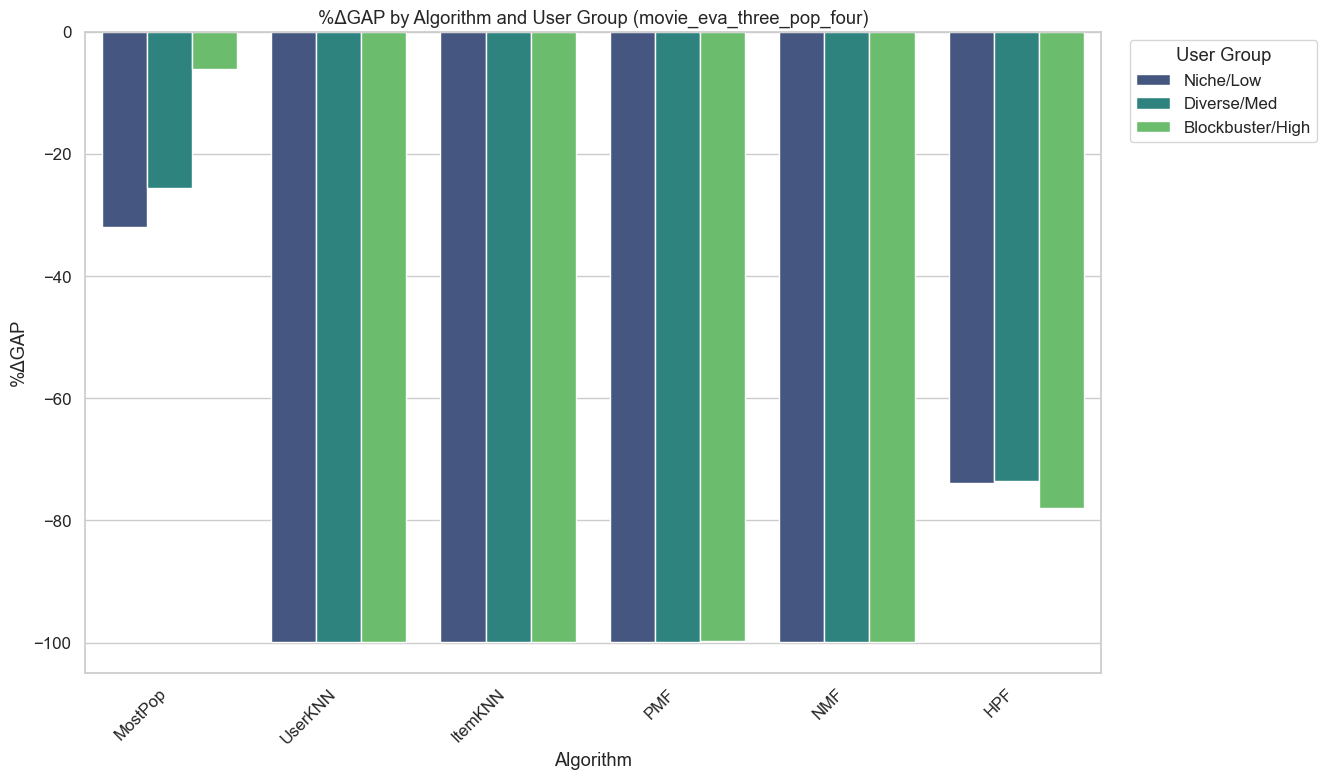


--- Summary Table: value (movie_eva_three_pop_four) ---



--- GAP T-test p-values (movie_eva_three_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_three_pop_four.png


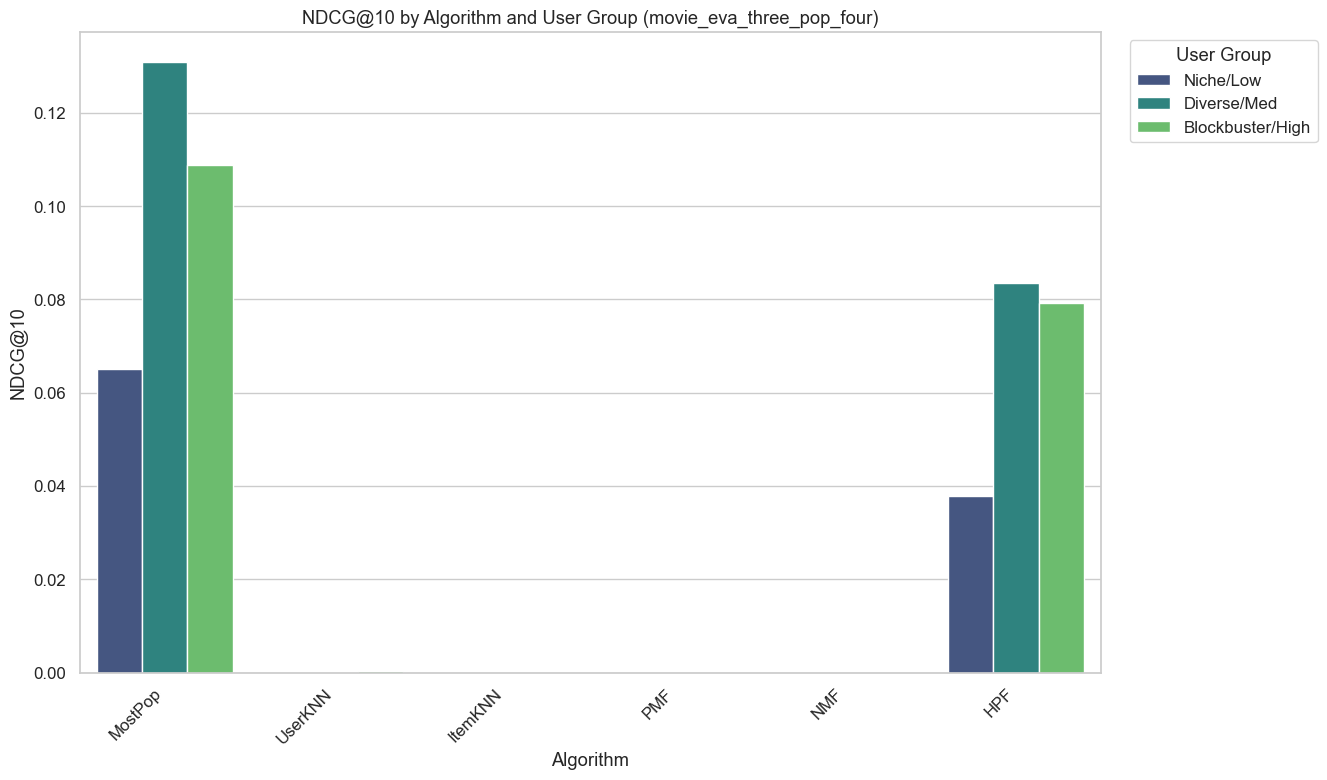


--- Summary Table: value (movie_eva_three_pop_four) ---



--- NDCG T-test p-values (movie_eva_three_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=movie, Eva=eva_three, Pop=pop_one
Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_three_pop_one.png


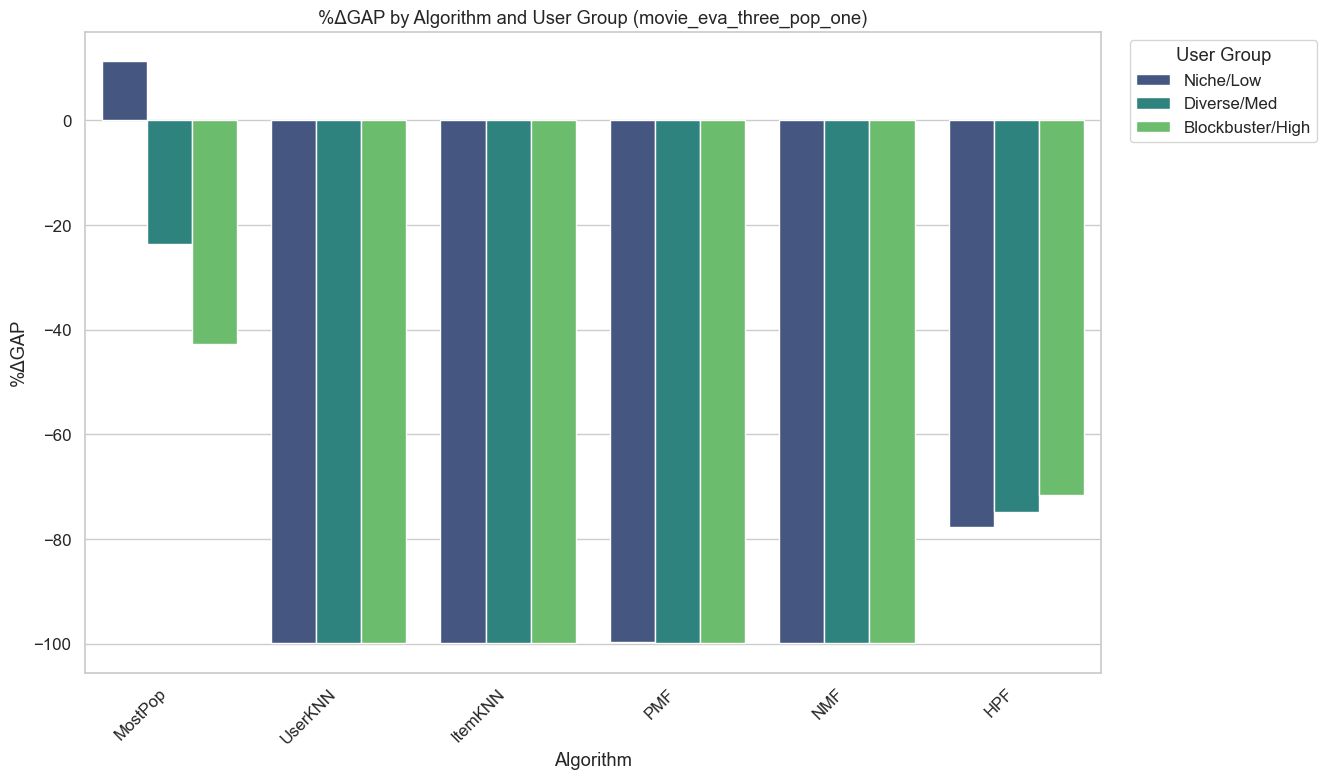


--- Summary Table: value (movie_eva_three_pop_one) ---



--- GAP T-test p-values (movie_eva_three_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_three_pop_one.png


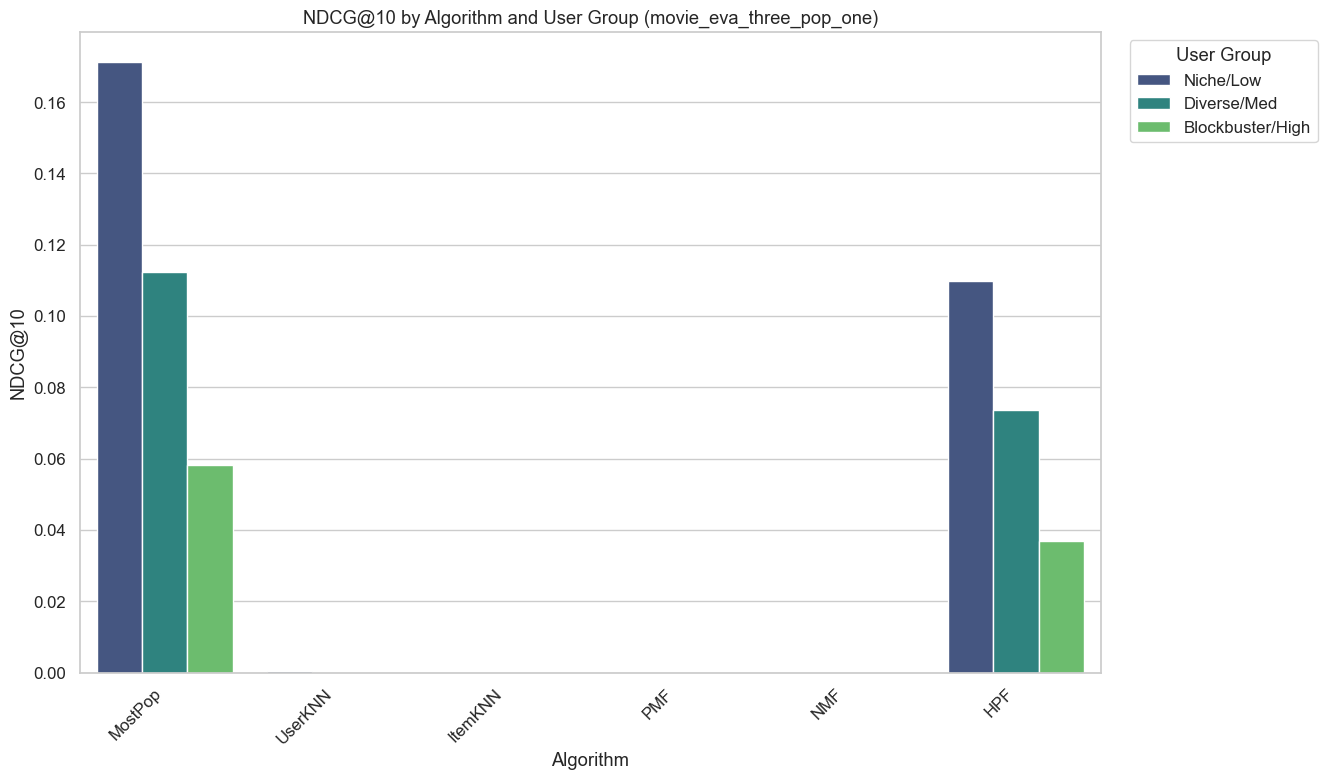


--- Summary Table: value (movie_eva_three_pop_one) ---



--- NDCG T-test p-values (movie_eva_three_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=movie, Eva=eva_three, Pop=pop_two
Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_three_pop_two.png


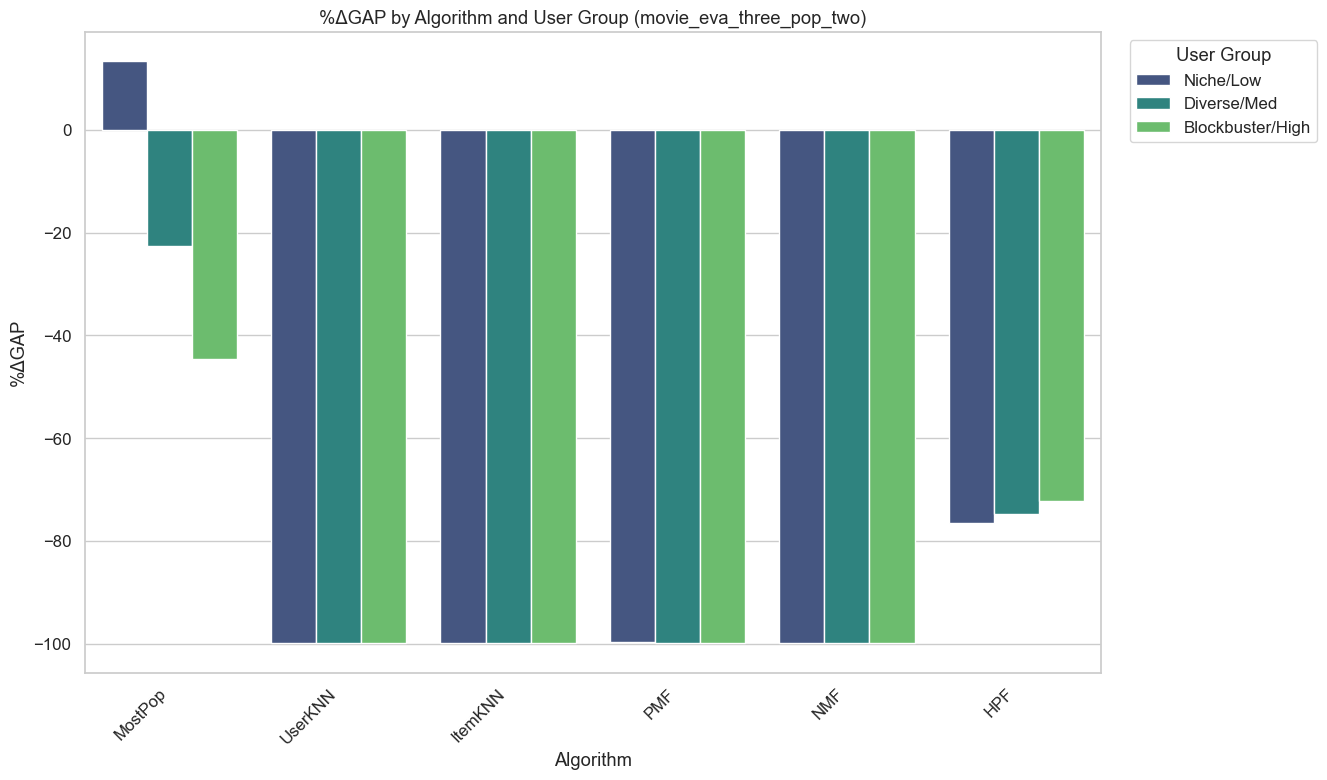


--- Summary Table: value (movie_eva_three_pop_two) ---



--- GAP T-test p-values (movie_eva_three_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_three_pop_two.png


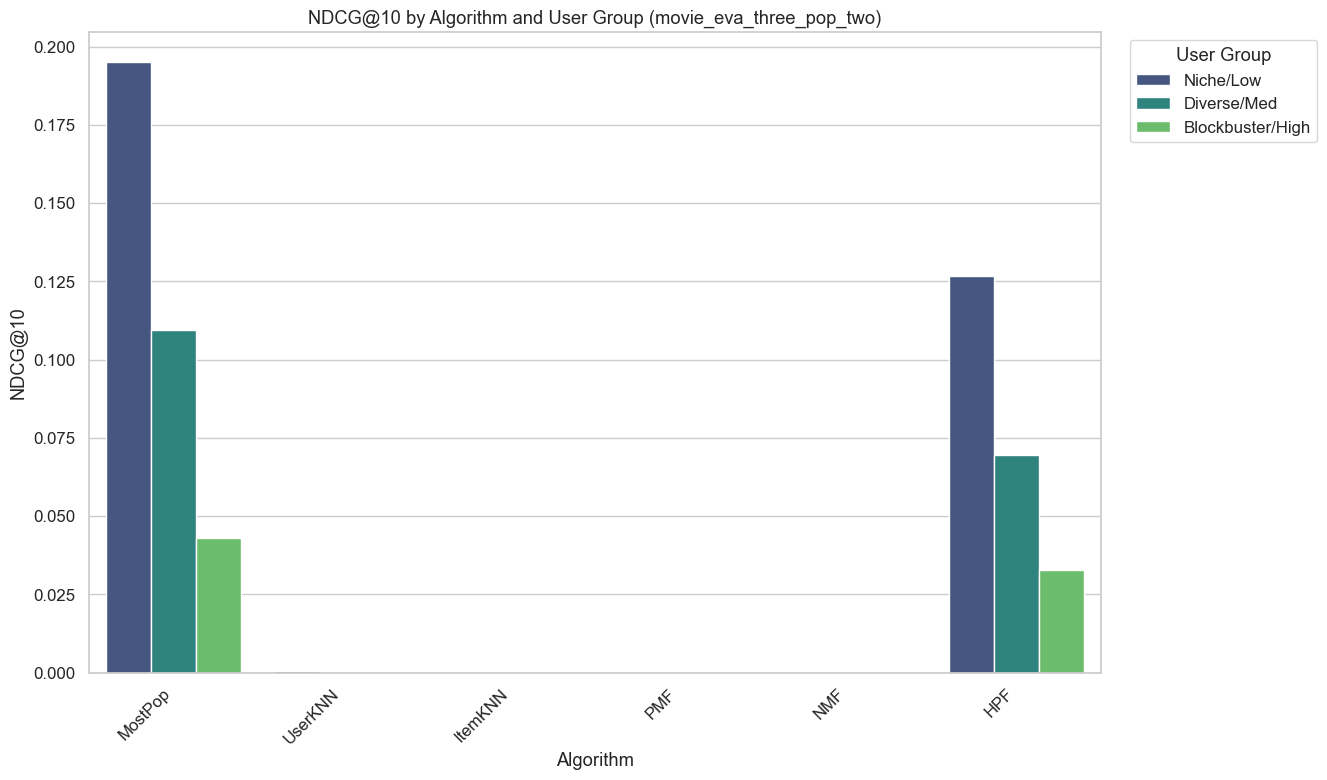


--- Summary Table: value (movie_eva_three_pop_two) ---



--- NDCG T-test p-values (movie_eva_three_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=movie, Eva=eva_two, Pop=pop_four
Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_two_pop_four.png


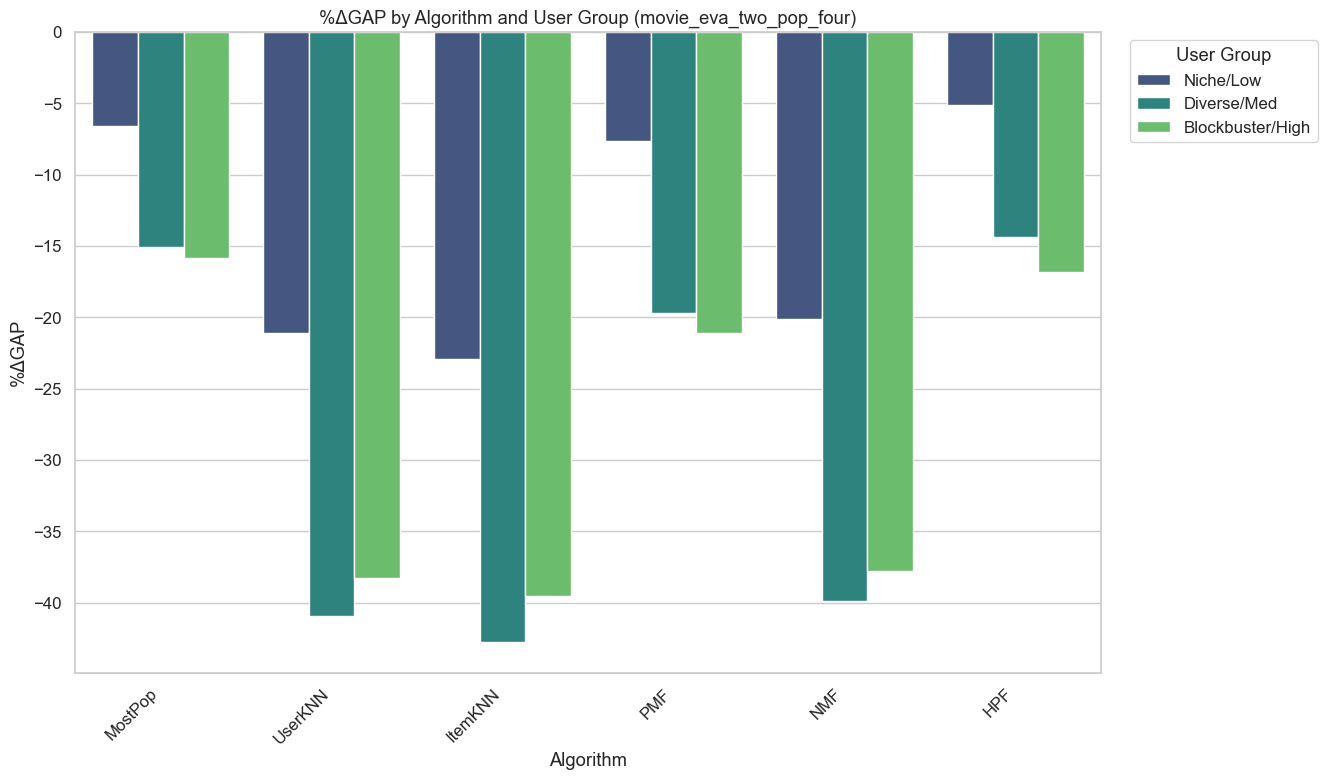


--- Summary Table: value (movie_eva_two_pop_four) ---



--- GAP T-test p-values (movie_eva_two_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_two_pop_four.png


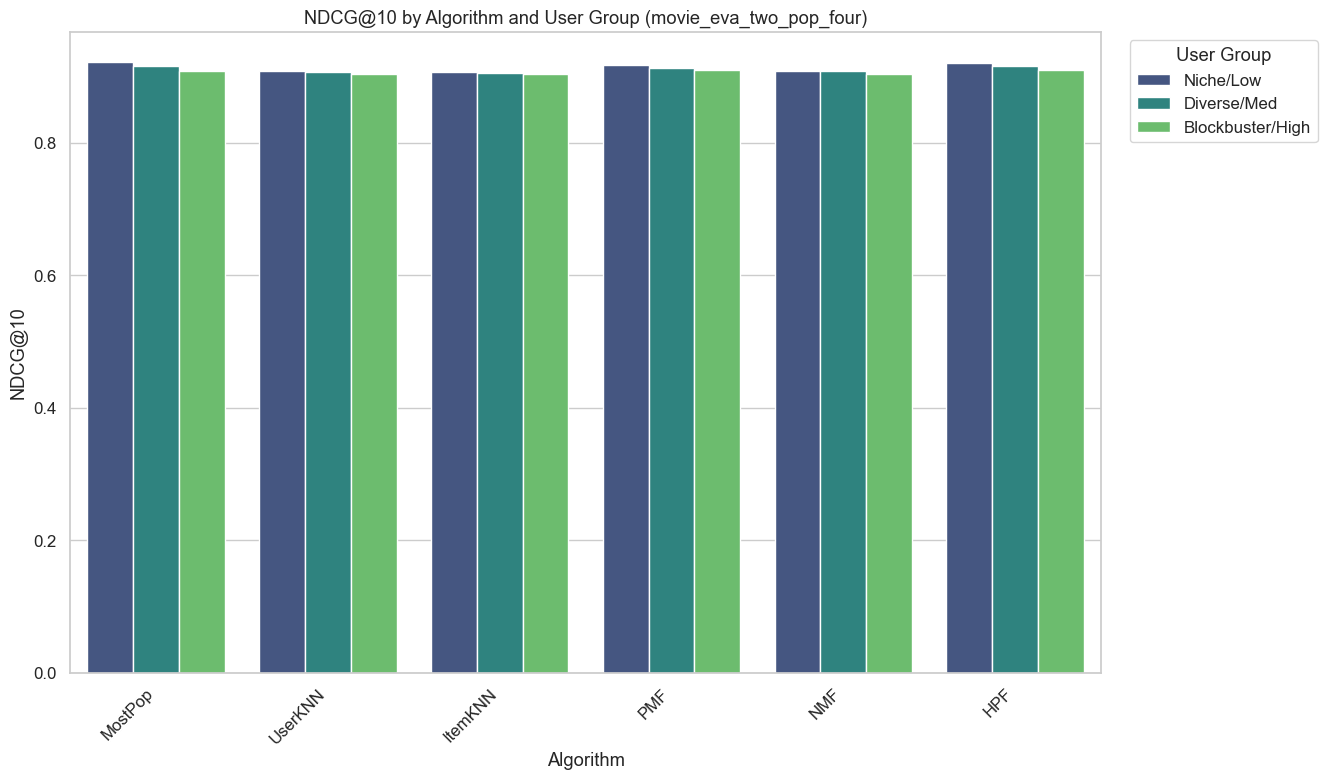


--- Summary Table: value (movie_eva_two_pop_four) ---



--- NDCG T-test p-values (movie_eva_two_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=movie, Eva=eva_two, Pop=pop_one
Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_two_pop_one.png


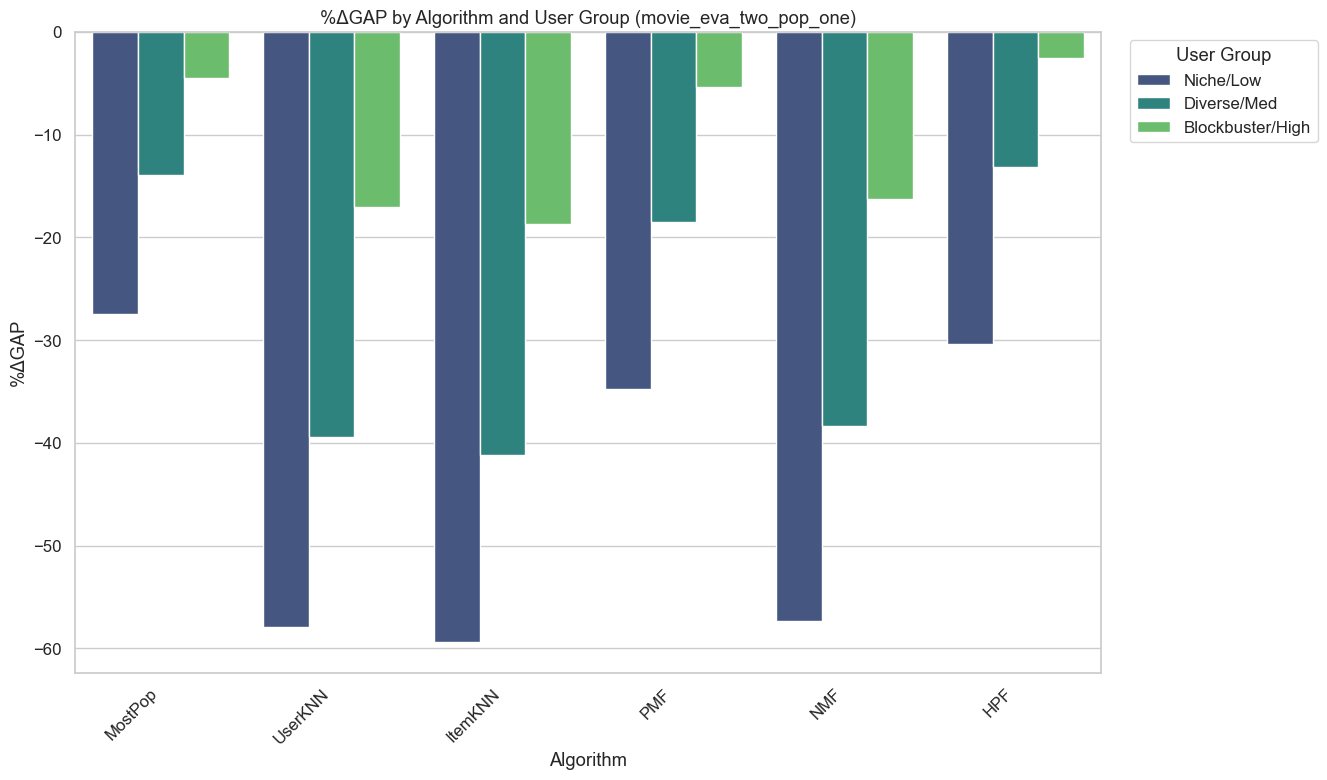


--- Summary Table: value (movie_eva_two_pop_one) ---



--- GAP T-test p-values (movie_eva_two_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_two_pop_one.png


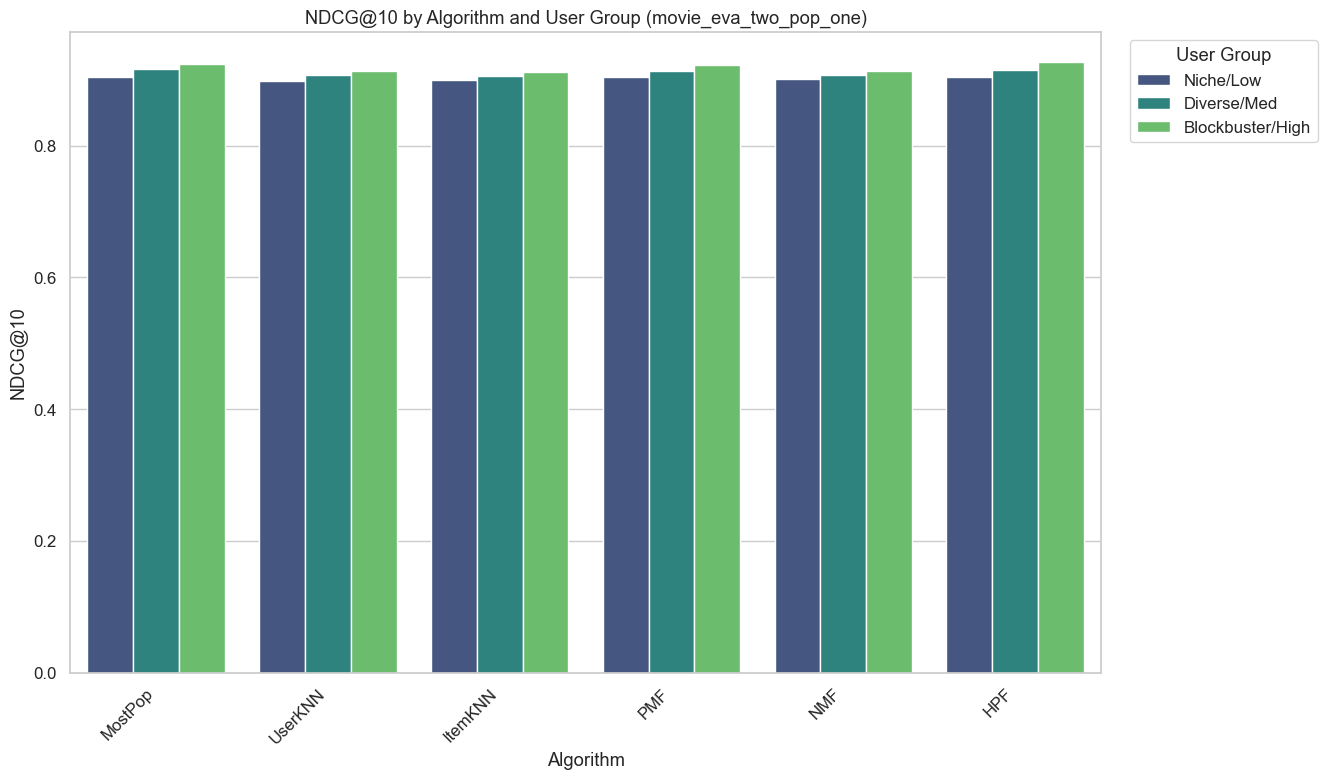


--- Summary Table: value (movie_eva_two_pop_one) ---



--- NDCG T-test p-values (movie_eva_two_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=movie, Eva=eva_two, Pop=pop_two
Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_two_pop_two.png


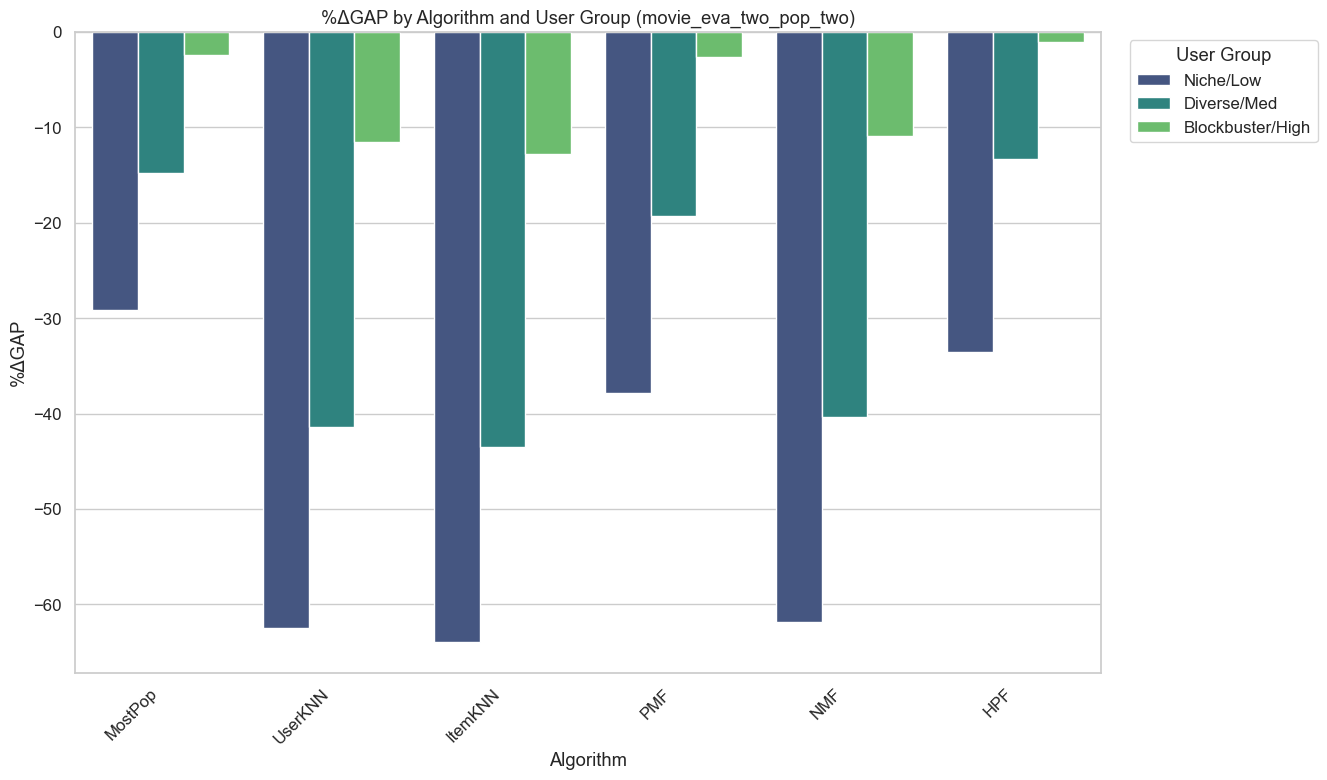


--- Summary Table: value (movie_eva_two_pop_two) ---



--- GAP T-test p-values (movie_eva_two_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_movie_eva_two_pop_two.png


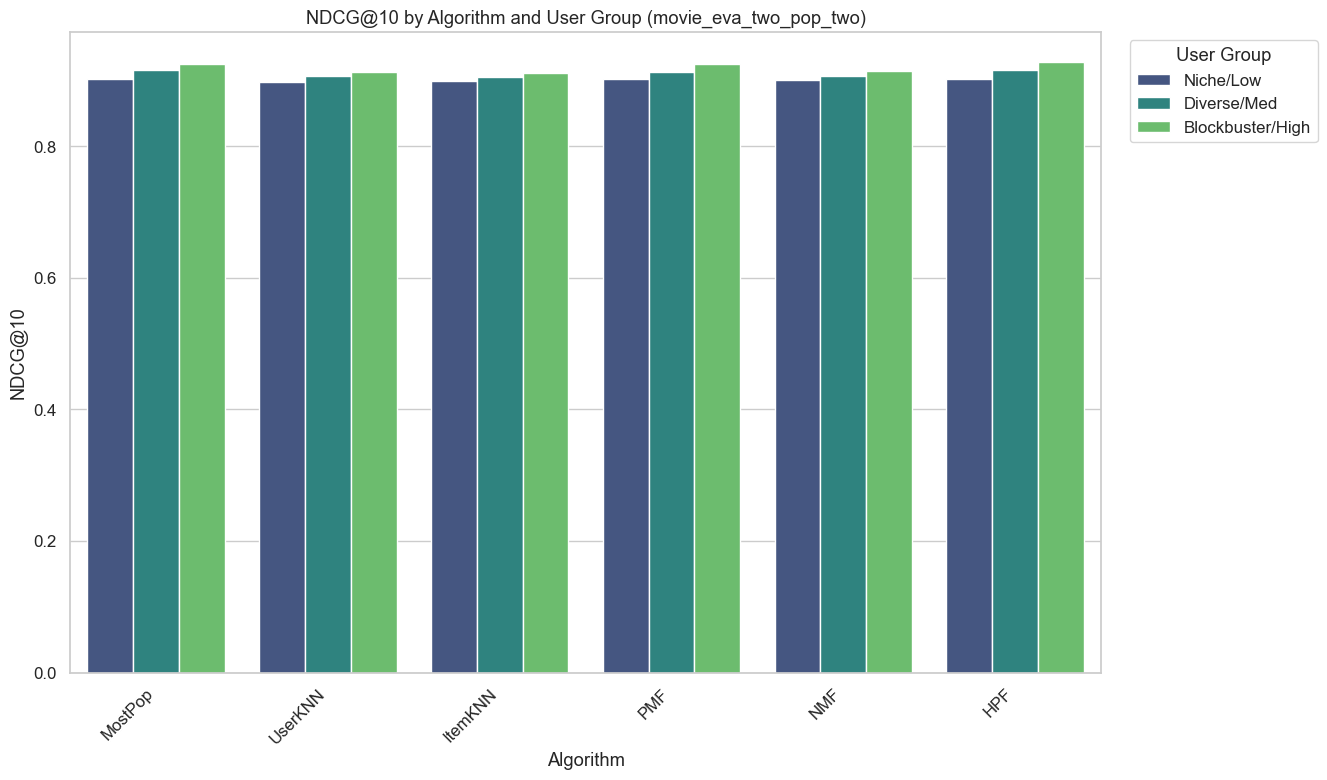


--- Summary Table: value (movie_eva_two_pop_two) ---



--- NDCG T-test p-values (movie_eva_two_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=music, Eva=eva_three, Pop=pop_four
Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_three_pop_four.png


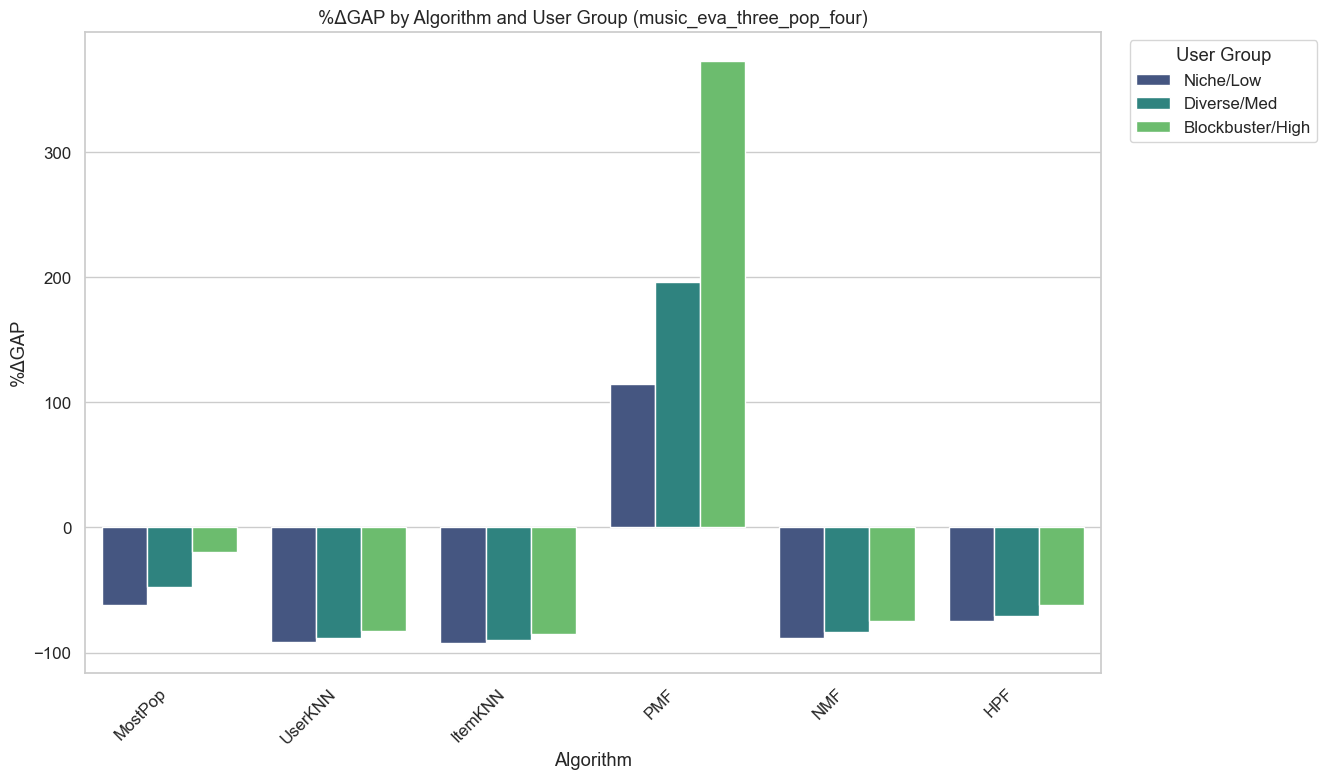


--- Summary Table: value (music_eva_three_pop_four) ---



--- GAP T-test p-values (music_eva_three_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_three_pop_four.png


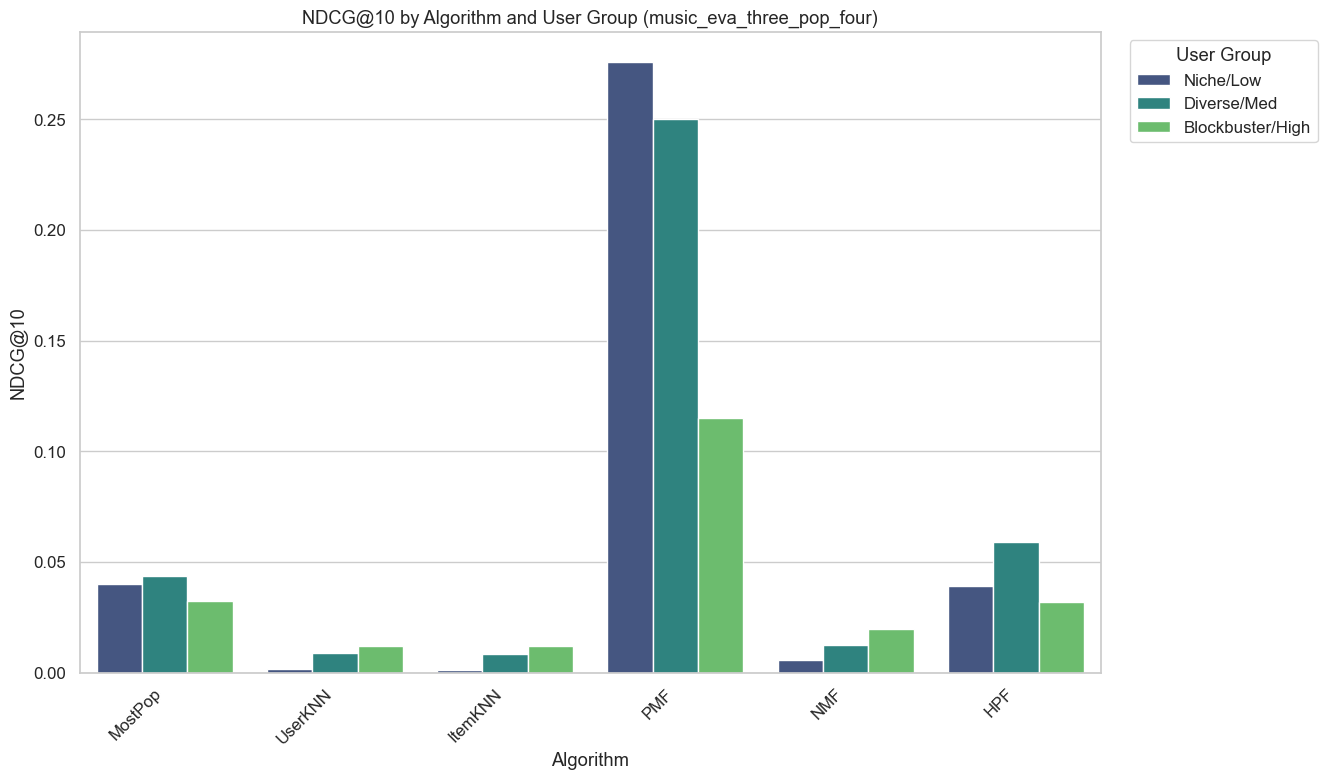


--- Summary Table: value (music_eva_three_pop_four) ---



--- NDCG T-test p-values (music_eva_three_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=music, Eva=eva_three, Pop=pop_one
Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_three_pop_one.png


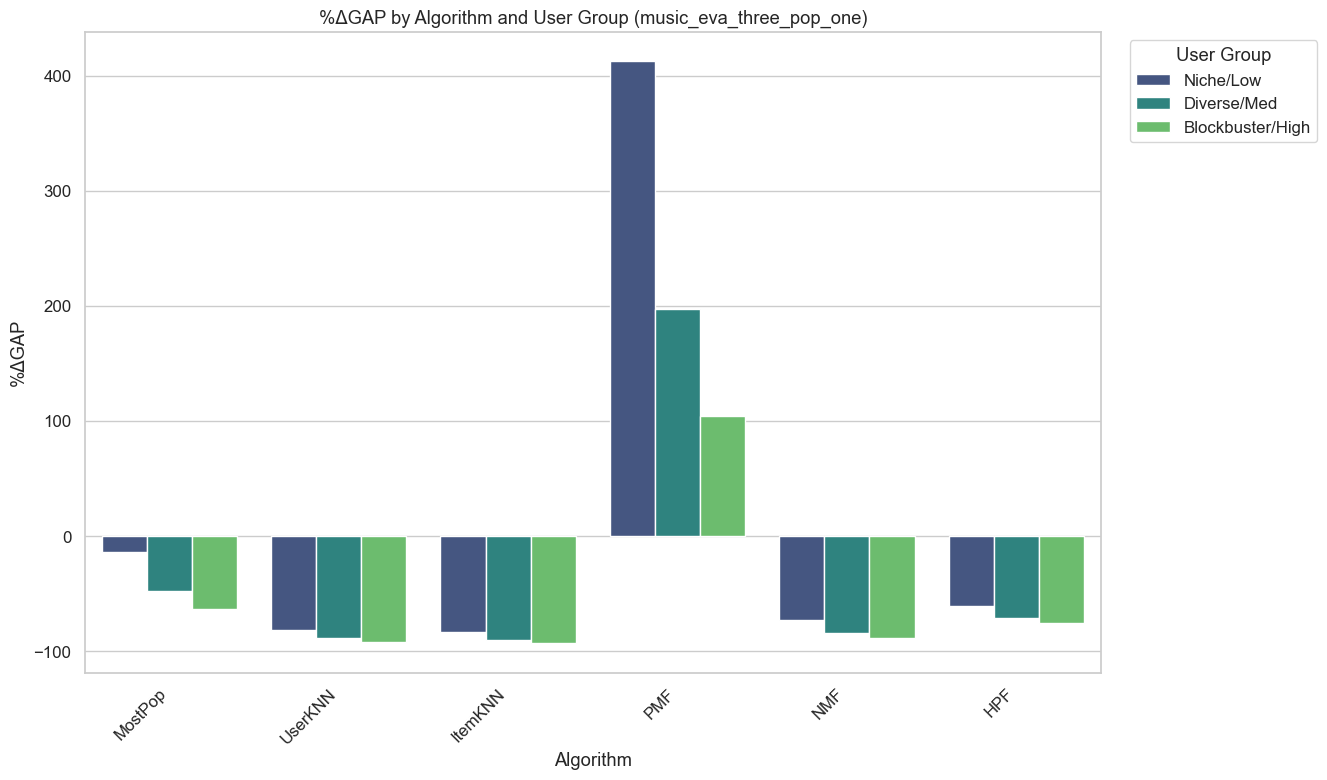


--- Summary Table: value (music_eva_three_pop_one) ---



--- GAP T-test p-values (music_eva_three_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_three_pop_one.png


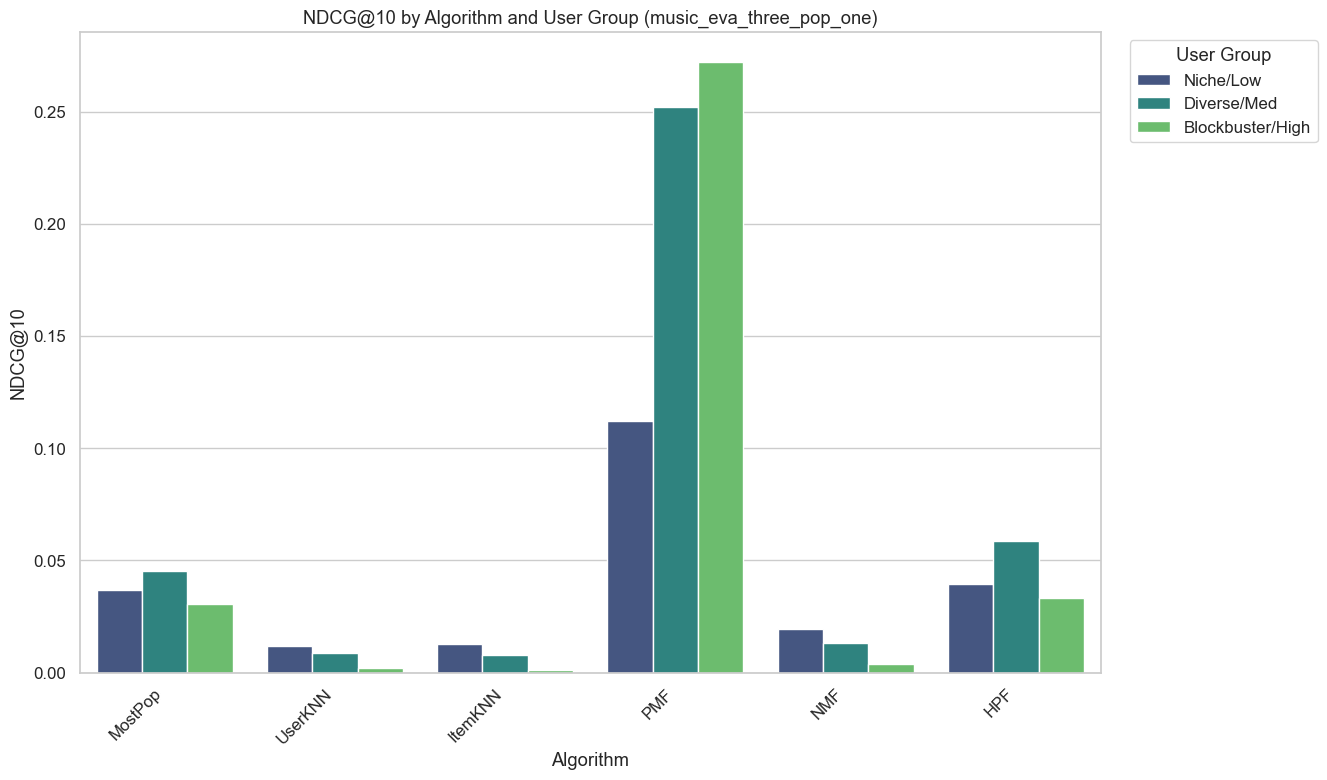


--- Summary Table: value (music_eva_three_pop_one) ---



--- NDCG T-test p-values (music_eva_three_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=music, Eva=eva_three, Pop=pop_two
Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_three_pop_two.png


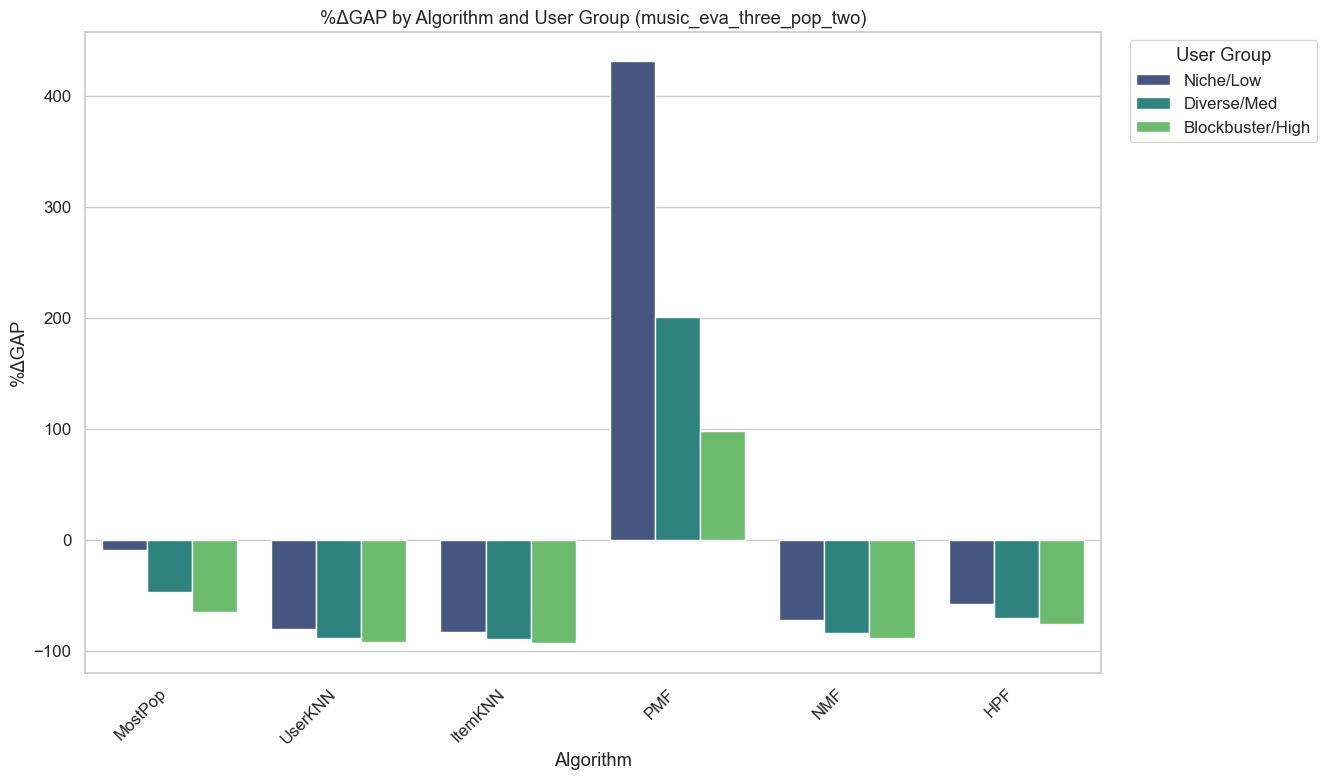


--- Summary Table: value (music_eva_three_pop_two) ---



--- GAP T-test p-values (music_eva_three_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_three_pop_two.png


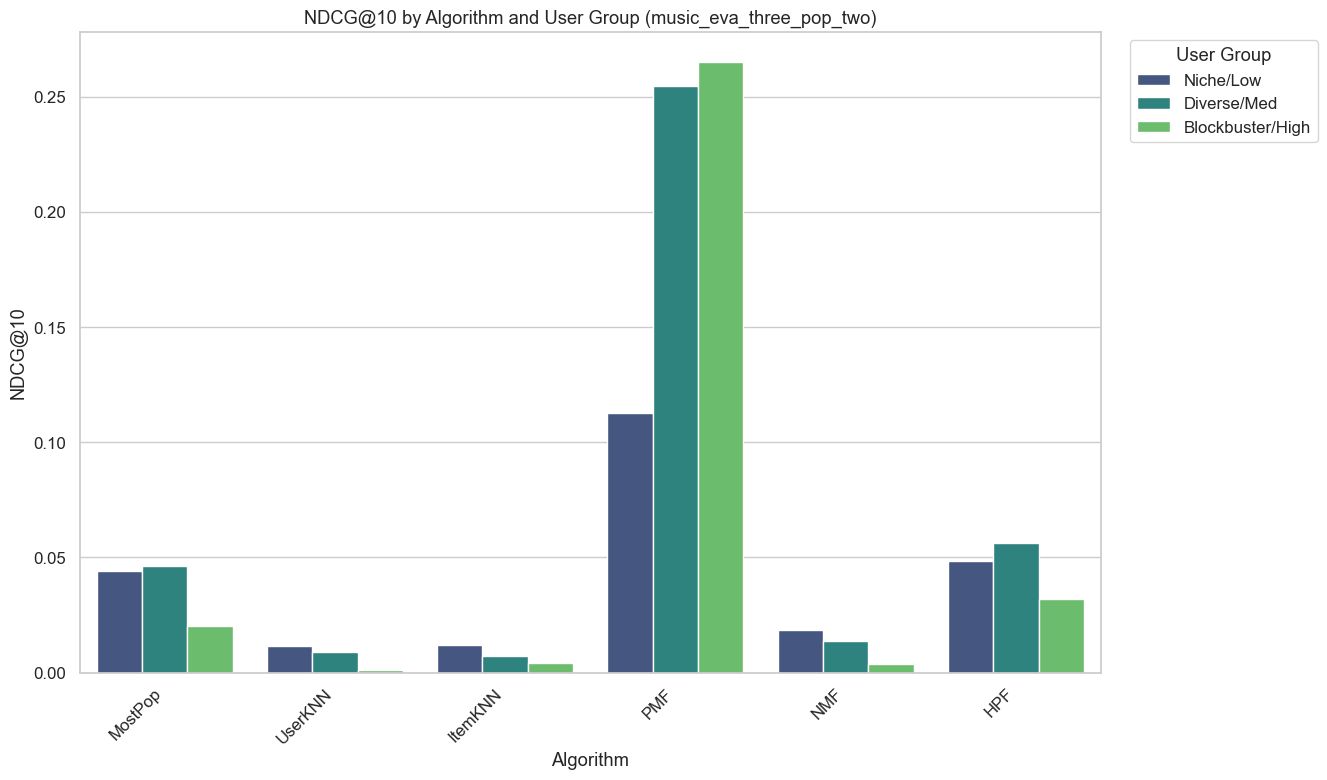


--- Summary Table: value (music_eva_three_pop_two) ---



--- NDCG T-test p-values (music_eva_three_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=music, Eva=eva_two, Pop=pop_four
Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_two_pop_four.png


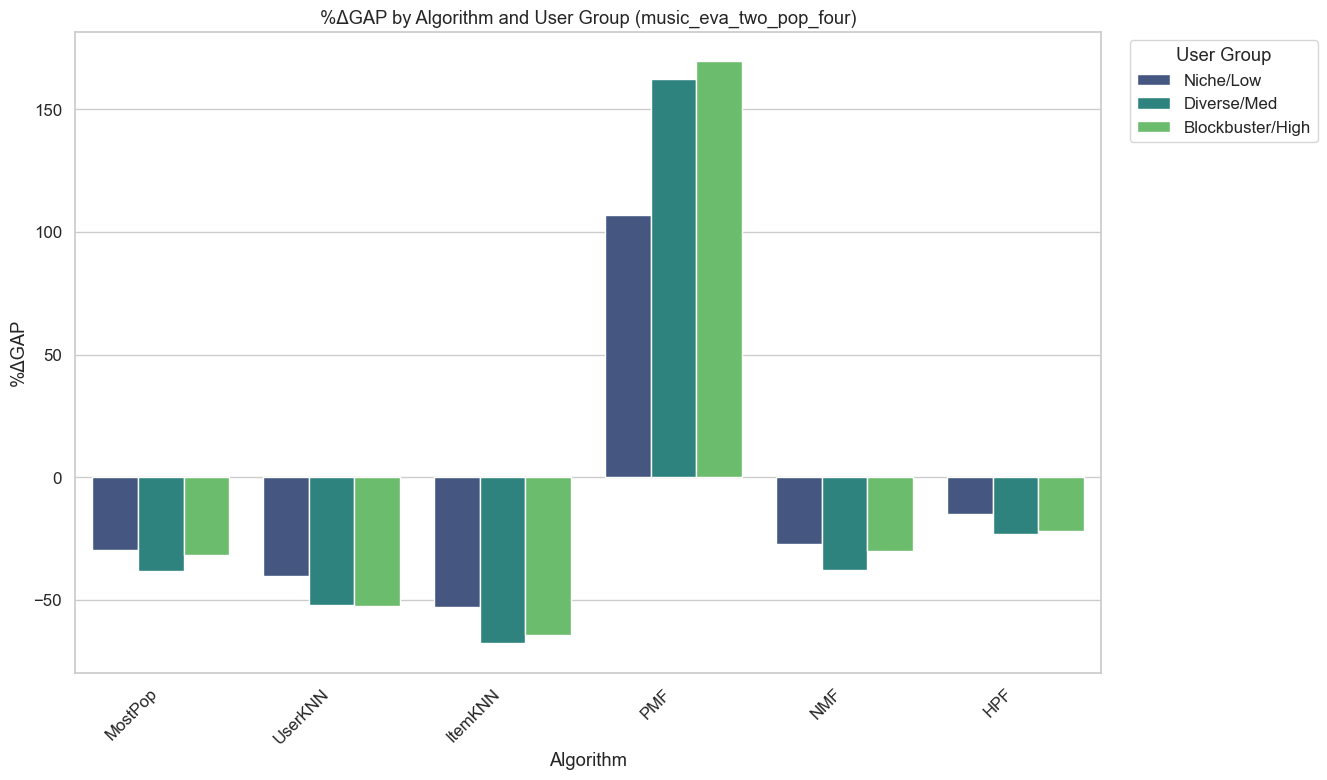


--- Summary Table: value (music_eva_two_pop_four) ---



--- GAP T-test p-values (music_eva_two_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_two_pop_four.png


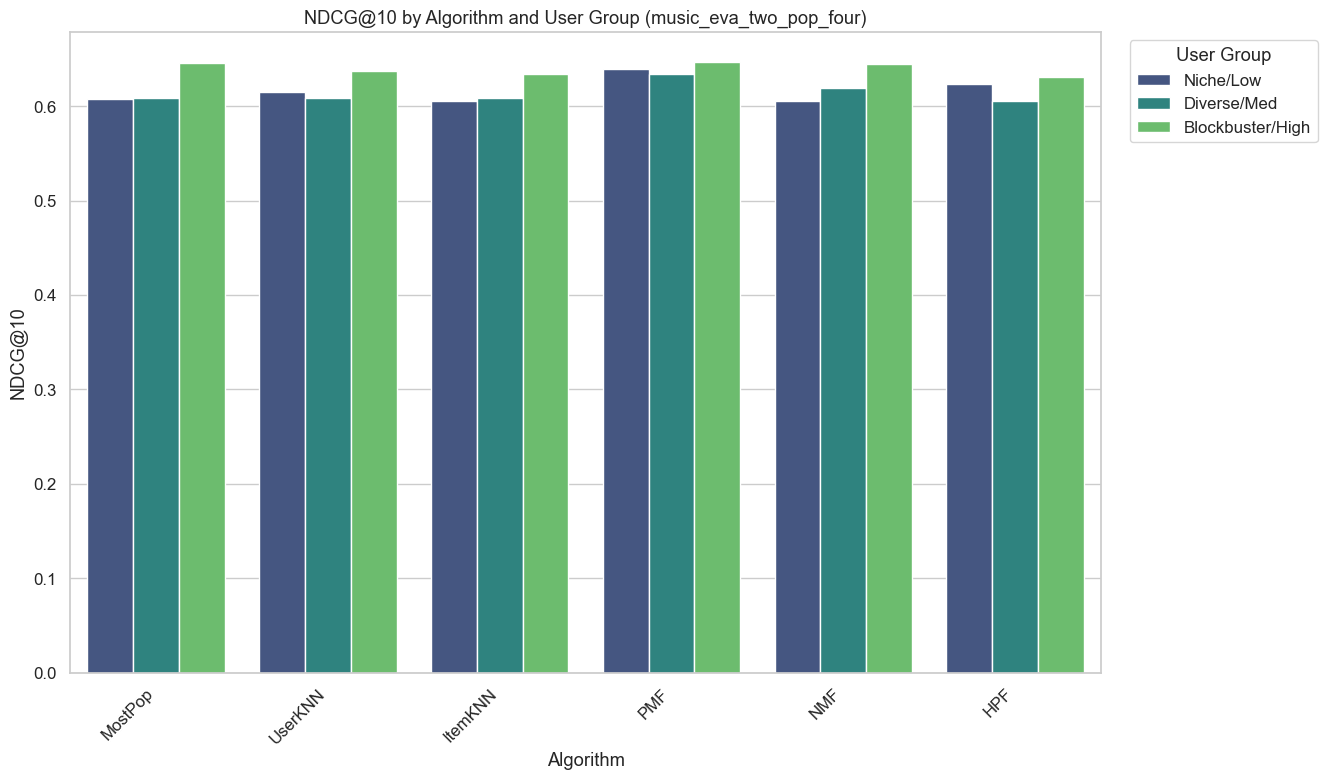


--- Summary Table: value (music_eva_two_pop_four) ---



--- NDCG T-test p-values (music_eva_two_pop_four) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=music, Eva=eva_two, Pop=pop_one
Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_two_pop_one.png


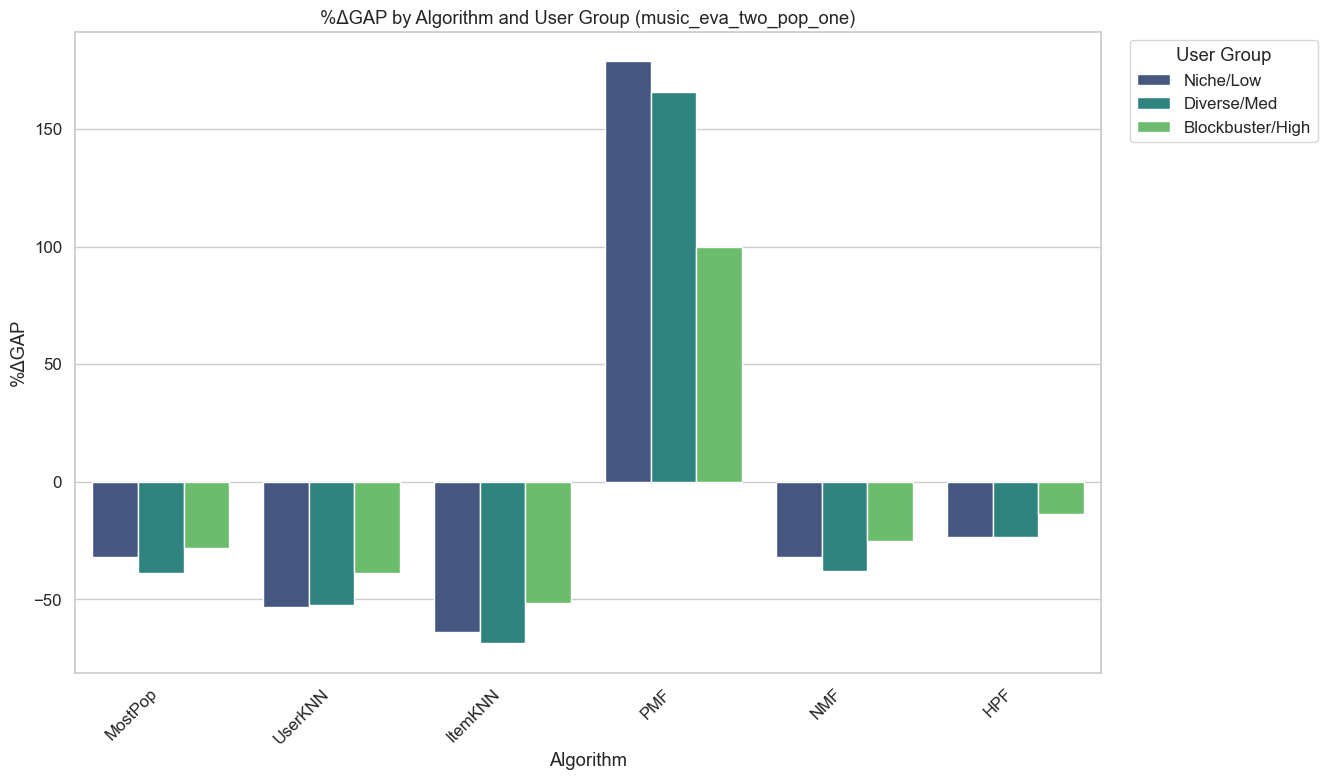


--- Summary Table: value (music_eva_two_pop_one) ---



--- GAP T-test p-values (music_eva_two_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_two_pop_one.png


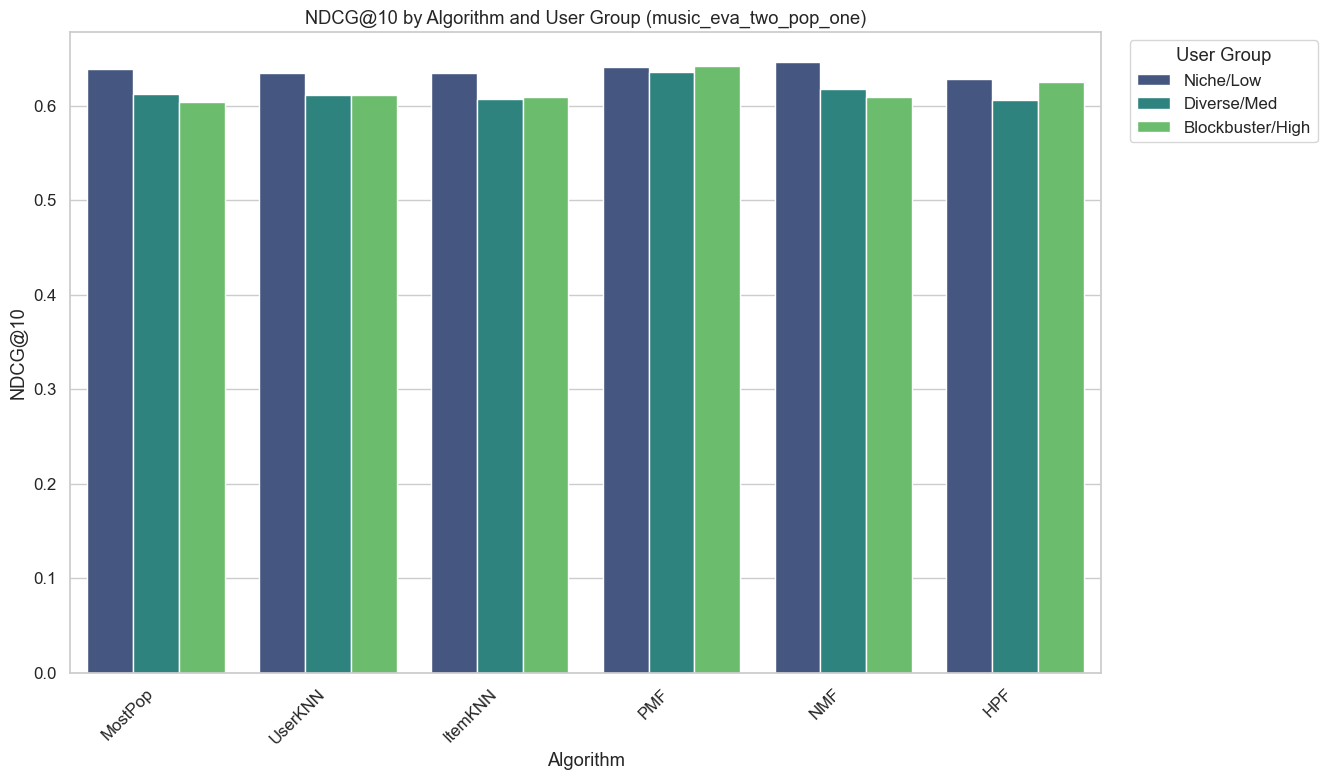


--- Summary Table: value (music_eva_two_pop_one) ---



--- NDCG T-test p-values (music_eva_two_pop_one) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))



Analyzing: Domain=music, Eva=eva_two, Pop=pop_two
Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_two_pop_two.png


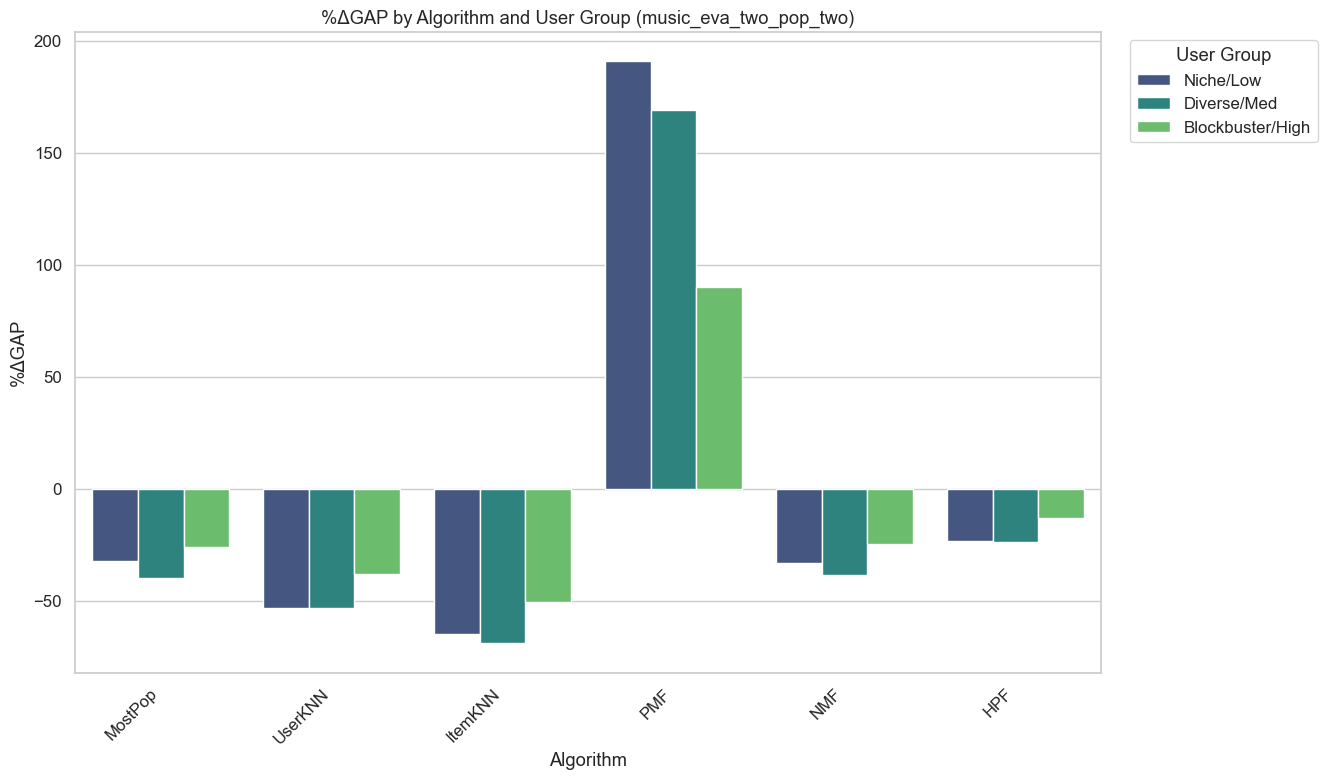


--- Summary Table: value (music_eva_two_pop_two) ---



--- GAP T-test p-values (music_eva_two_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


Saved plot: mitigated_results03/analysis_figures/value_by_group_music_eva_two_pop_two.png


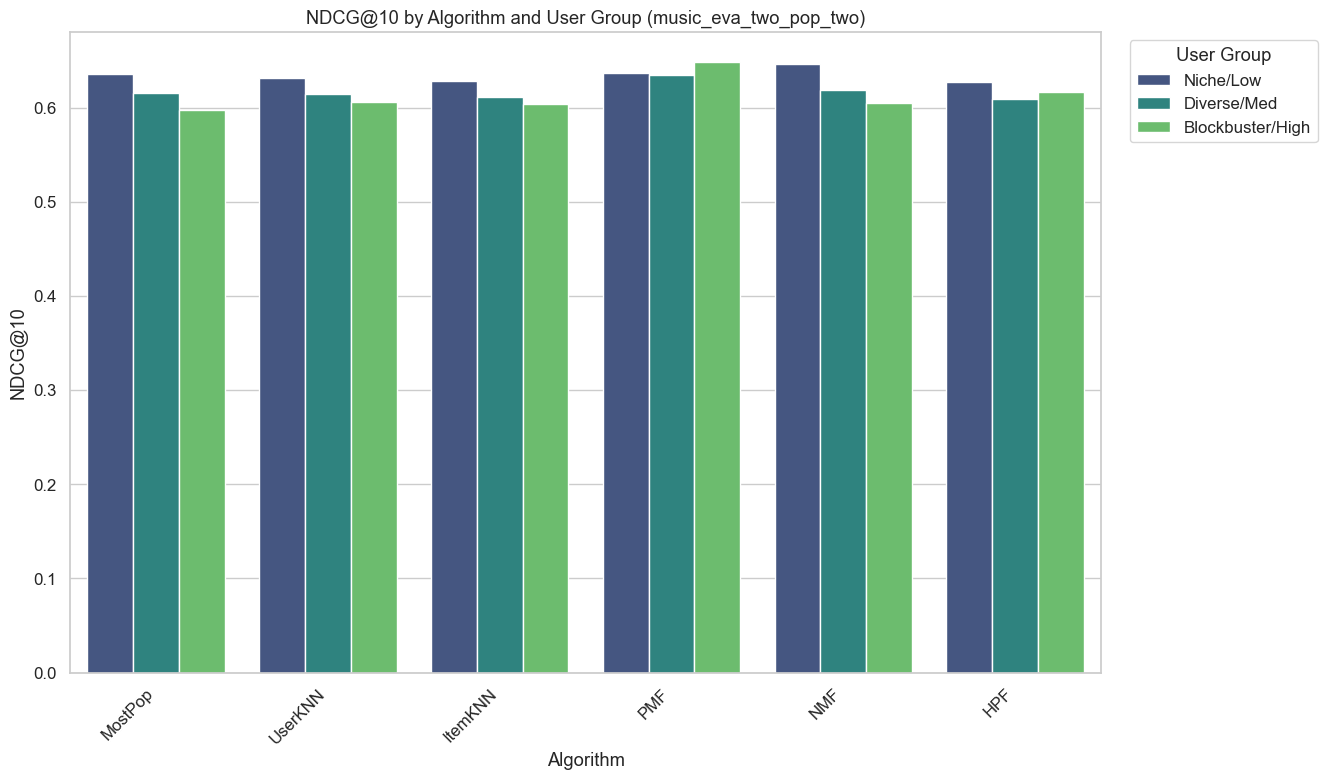


--- Summary Table: value (music_eva_two_pop_two) ---



--- NDCG T-test p-values (music_eva_two_pop_two) ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16424\930381291.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))


In [5]:
if not df_consolidated.empty:
    # Iterate through each combination found in the consolidated data
    for (domain, eva, pop), group_data in df_consolidated.groupby(['domain', 'evaluation_strategy', 'popularity_notion']):
        print(f"\n{'='*80}")
        print(f"Analyzing: Domain={domain}, Eva={eva}, Pop={pop}")
        print(f"{'='*80}")

        # --- %ΔGAP Analysis --- 
        df_gap = group_data[(group_data['metric_type'] == 'GAP') & (group_data['user_group'] != 'N/A')].copy()
        if not df_gap.empty:
            title_sfx = f"{domain}_{eva}_{pop}"
            plot_metric_by_group(df_gap, 'value', title_sfx, '%ΔGAP', title_sfx)
            display_summary_table(df_gap, 'value', title_sfx)
            
            # Display GAP T-tests
            df_gap_ttest = group_data[(group_data['metric_type'] == 'GAP_TTEST')].copy()
            if not df_gap_ttest.empty:
                algo_order_ttest = [algo for algo in ALGORITHMS if algo in df_gap_ttest['algorithm'].unique()]
                pivot_gap_ttest = pd.pivot_table(df_gap_ttest, values='p_value', index='algorithm', columns='comparison_group')
                pivot_gap_ttest = pivot_gap_ttest.reindex(algo_order_ttest)
                print(f"\n--- GAP T-test p-values ({title_sfx}) ---")
                display(pivot_gap_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))
            else:
                print(f"\n--- No GAP T-test data found for {title_sfx} ---")
        else:
            print(f"\n--- No %ΔGAP data found for {domain}, {eva}, {pop} ---")

        # --- NDCG@10 Analysis --- 
        df_ndcg = group_data[(group_data['metric_type'] == 'NDCG') & (group_data['user_group'] != 'N/A')].copy()
        if not df_ndcg.empty:
            title_sfx = f"{domain}_{eva}_{pop}"
            plot_metric_by_group(df_ndcg, 'value', title_sfx, 'NDCG@10', title_sfx)
            display_summary_table(df_ndcg, 'value', title_sfx)
            
            # Display NDCG T-tests
            df_ndcg_ttest = group_data[(group_data['metric_type'] == 'NDCG_TTEST')].copy()
            if not df_ndcg_ttest.empty:
                algo_order_ttest = [algo for algo in ALGORITHMS if algo in df_ndcg_ttest['algorithm'].unique()]
                pivot_ndcg_ttest = pd.pivot_table(df_ndcg_ttest, values='p_value', index='algorithm', columns='comparison_group')
                pivot_ndcg_ttest = pivot_ndcg_ttest.reindex(algo_order_ttest)
                print(f"\n--- NDCG T-test p-values ({title_sfx}) ---")
                display(pivot_ndcg_ttest.style.format('{:.3g}').applymap(lambda x: 'font-weight: bold' if x < 0.05 else ''))
            else:
                 print(f"\n--- No NDCG T-test data found for {title_sfx} ---")
        else:
            print(f"\n--- No NDCG@10 data found for {domain}, {eva}, {pop} ---")
            
else:
    print("Consolidated DataFrame is empty. Cannot perform analysis.")

### 4.3 Cross-Cutting Comparisons (Excluding MF)

Now, let's create plots that directly compare results across domains, evaluation strategies, or popularity notions for specific metrics and algorithms.

Saved plot: mitigated_results03/analysis_figures/GAP_eva_comparison_music_pop_one.png


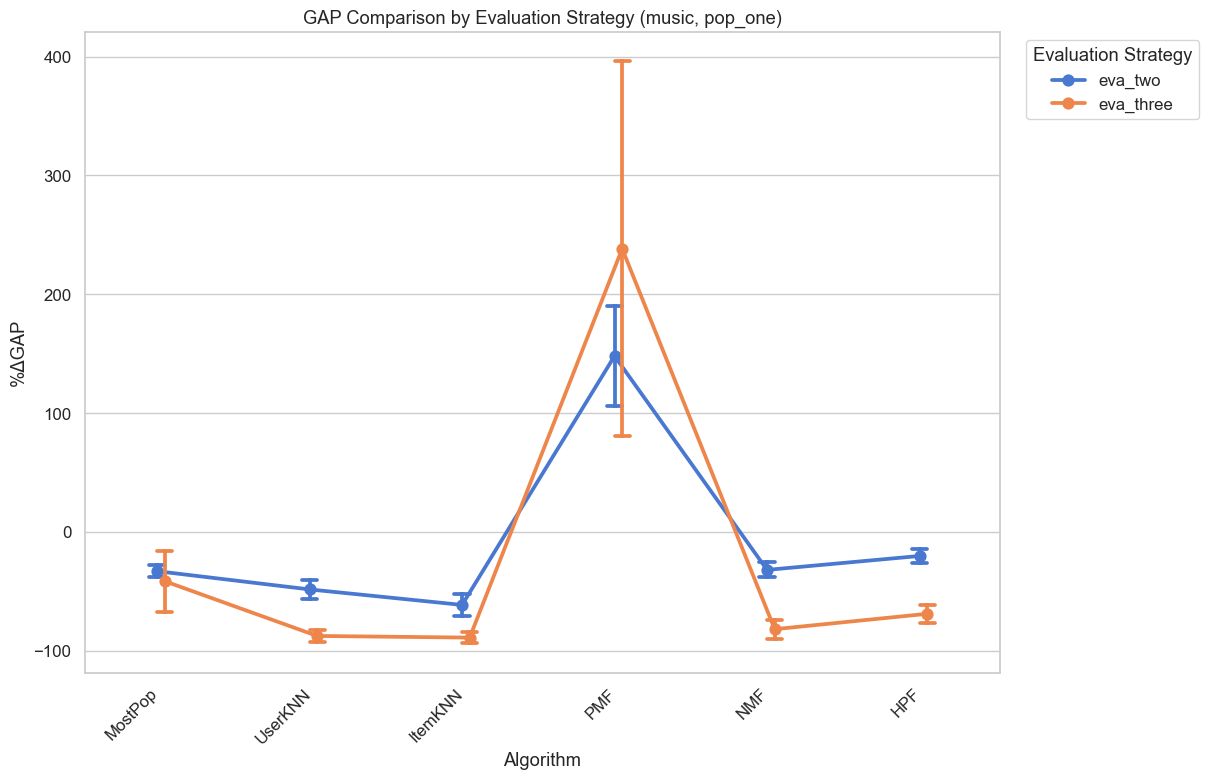

Saved plot: mitigated_results03/analysis_figures/NDCG_eva_comparison_music_pop_one.png


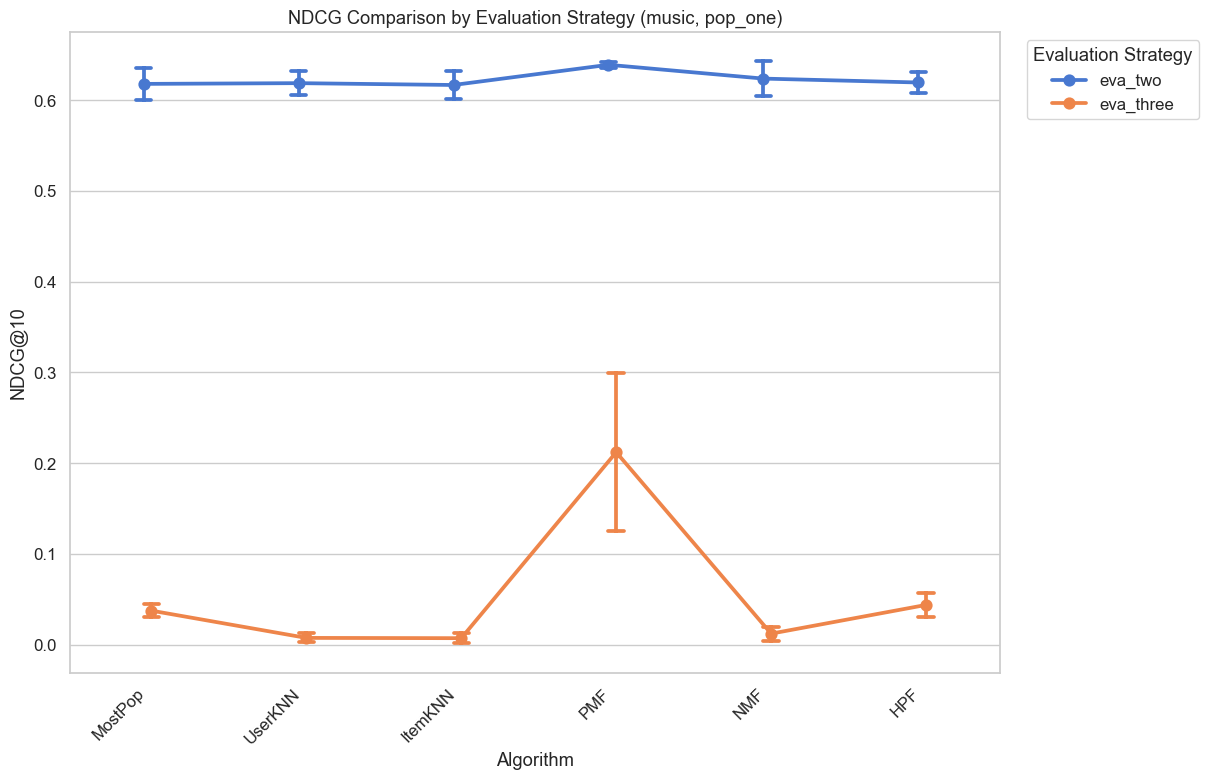

Saved plot: mitigated_results03/analysis_figures/GAP_eva_comparison_music_pop_two.png


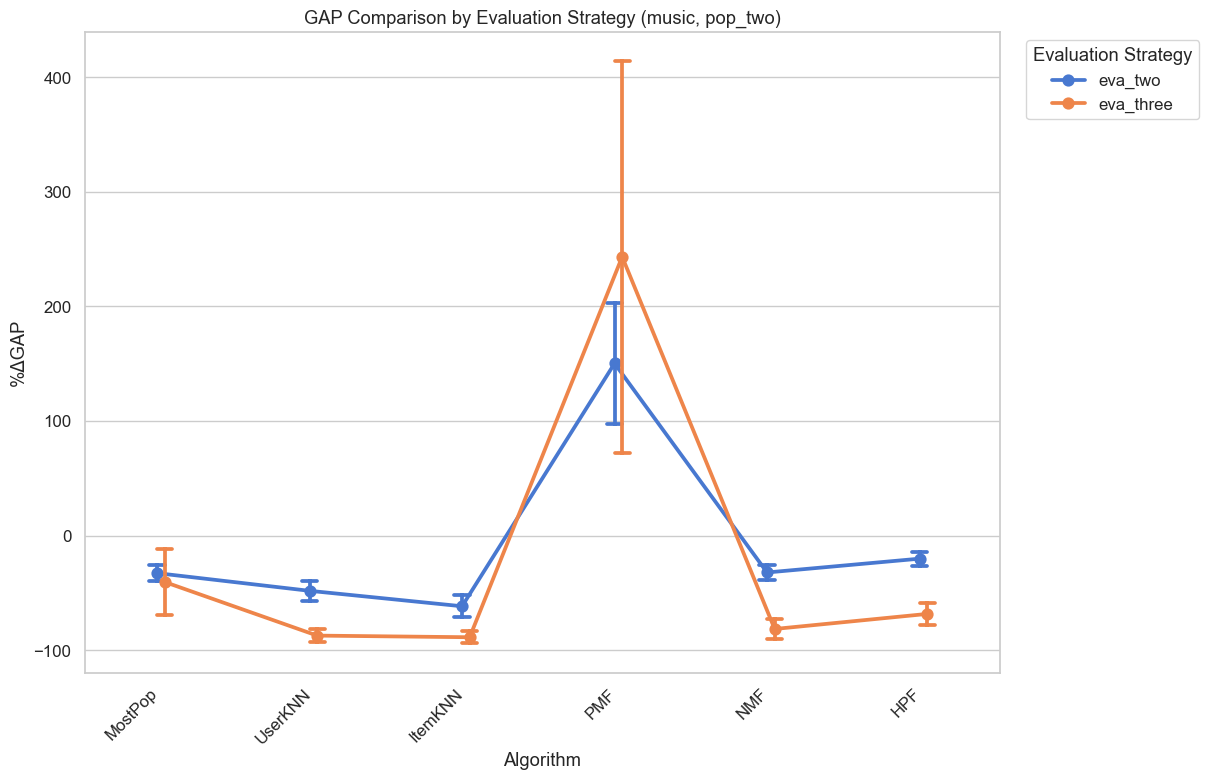

Saved plot: mitigated_results03/analysis_figures/NDCG_eva_comparison_music_pop_two.png


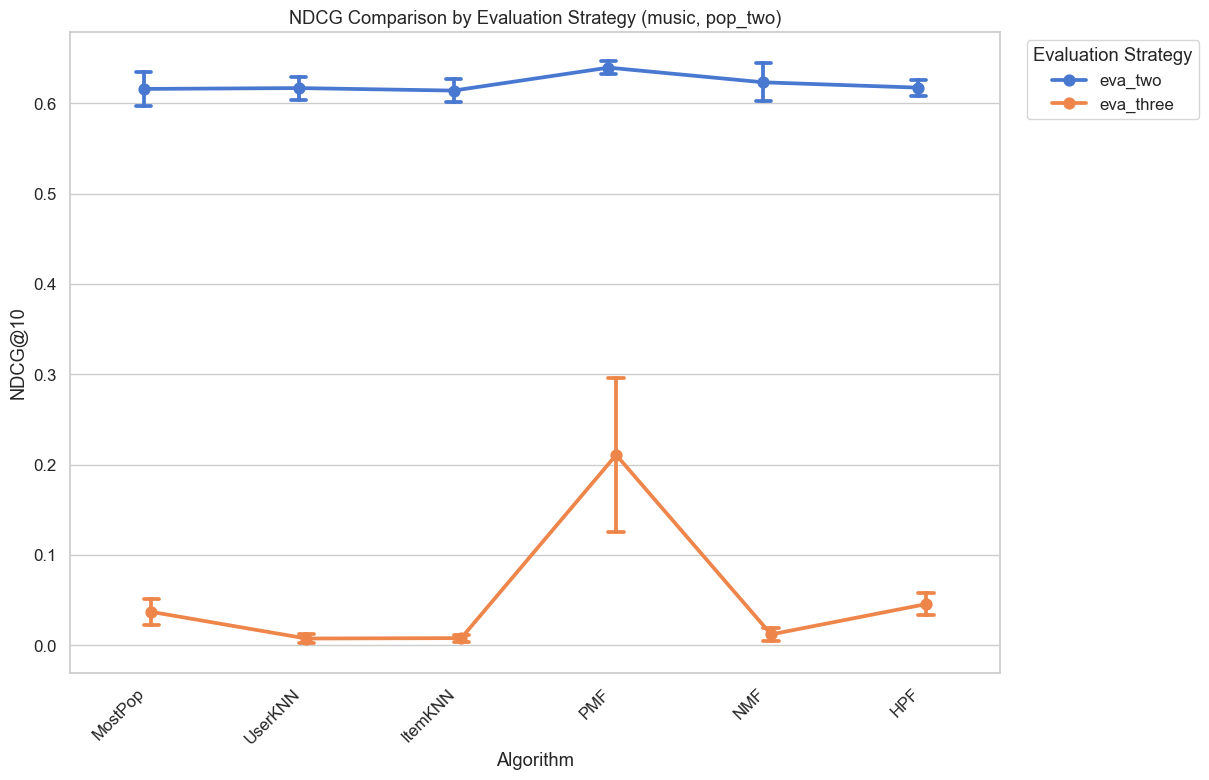

Saved plot: mitigated_results03/analysis_figures/GAP_eva_comparison_music_pop_four.png


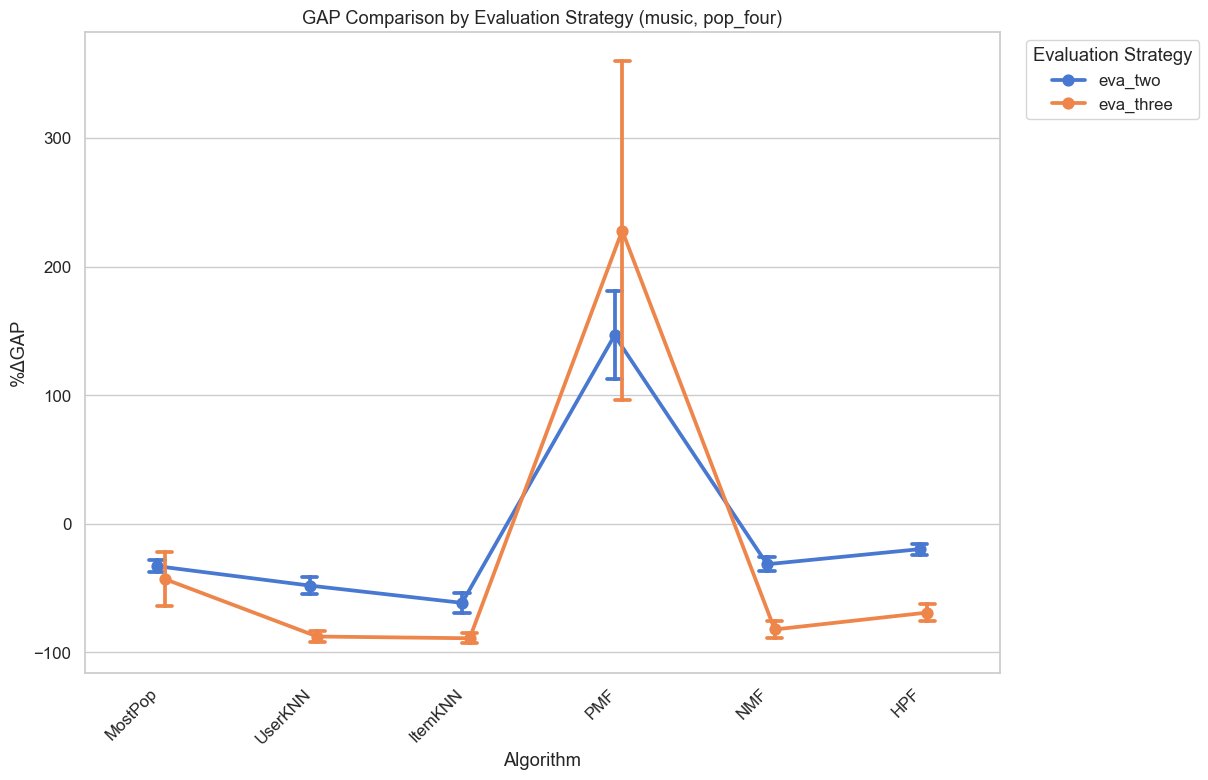

Saved plot: mitigated_results03/analysis_figures/NDCG_eva_comparison_music_pop_four.png


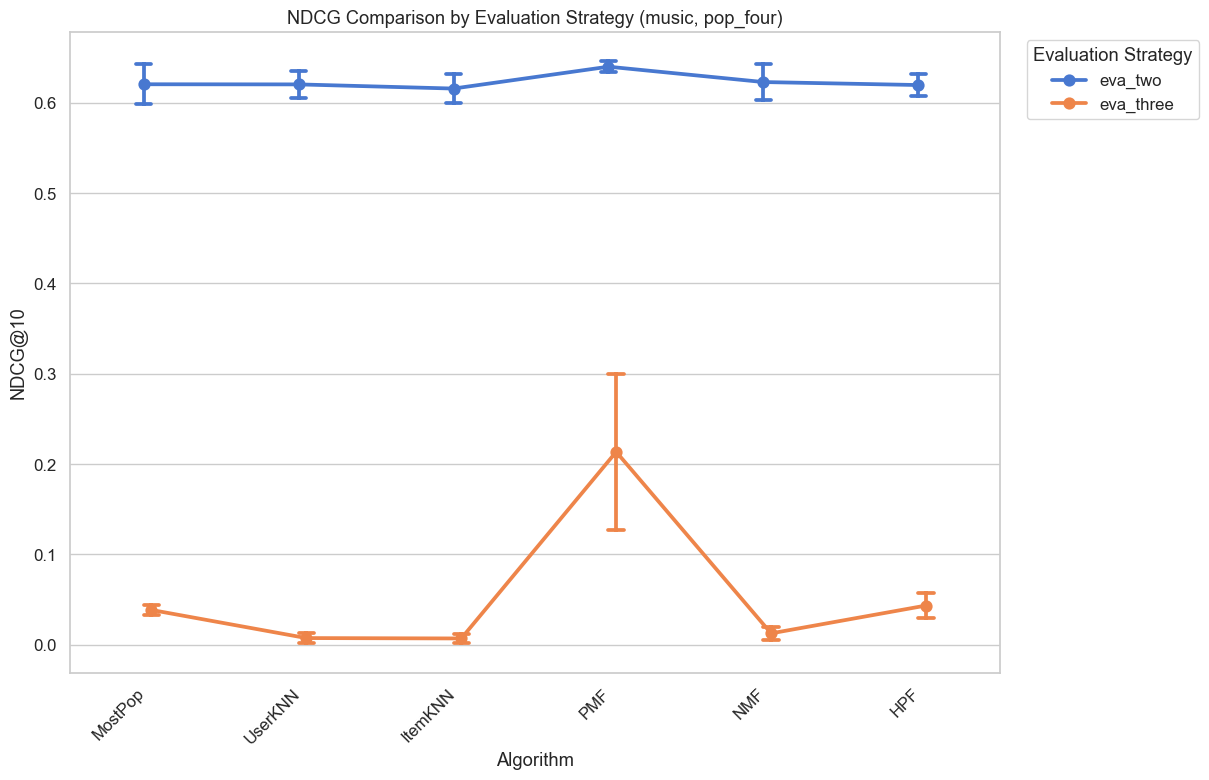

Saved plot: mitigated_results03/analysis_figures/GAP_eva_comparison_movie_pop_one.png


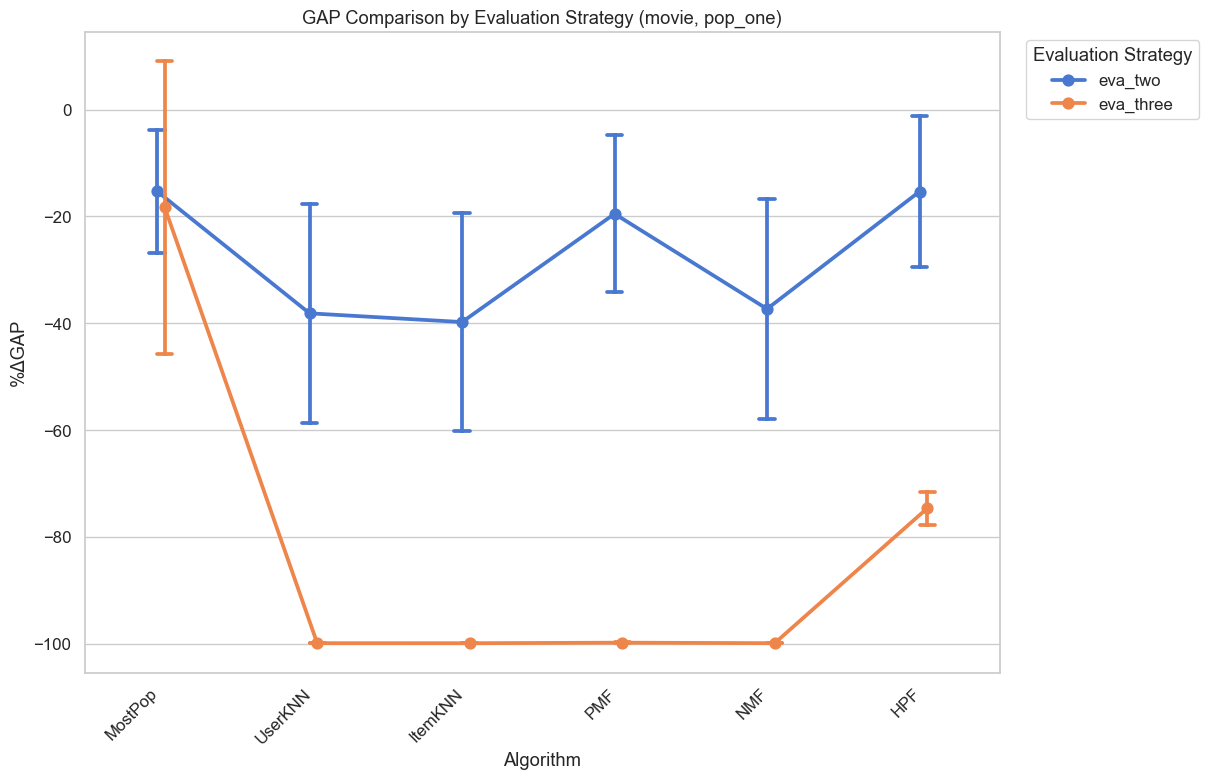

Saved plot: mitigated_results03/analysis_figures/NDCG_eva_comparison_movie_pop_one.png


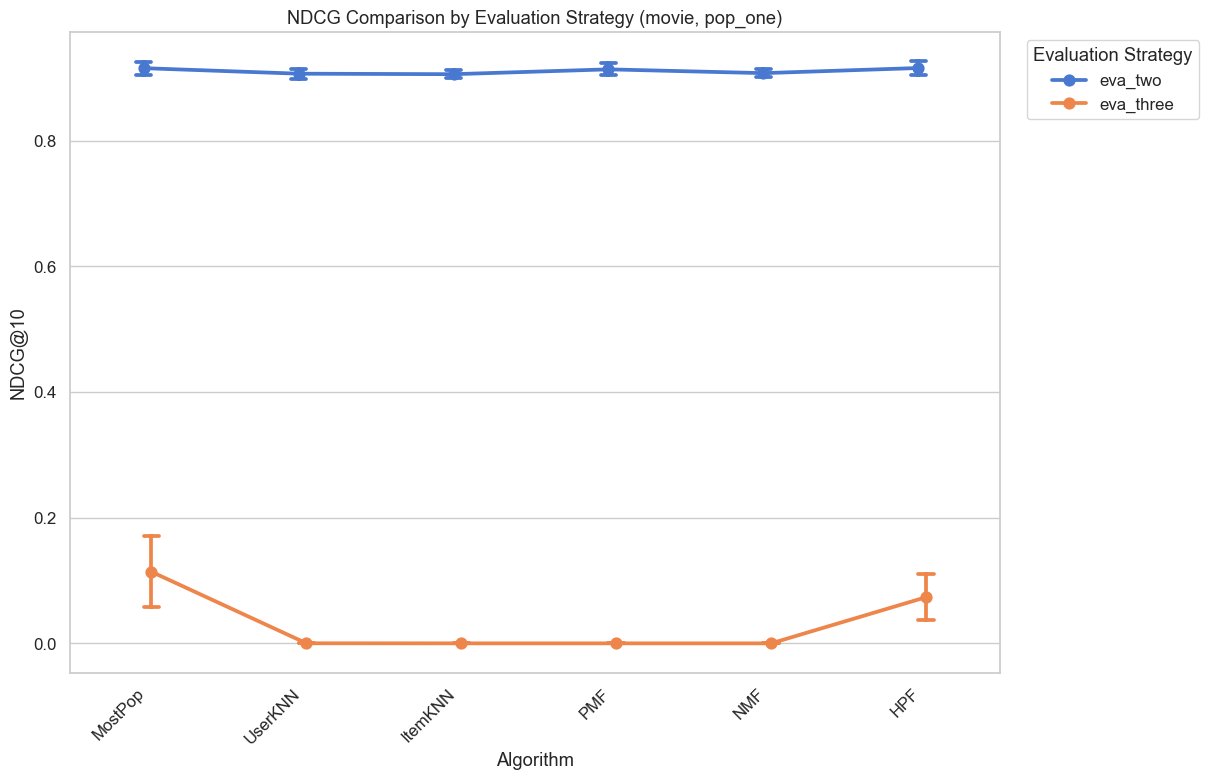

Saved plot: mitigated_results03/analysis_figures/GAP_eva_comparison_movie_pop_two.png


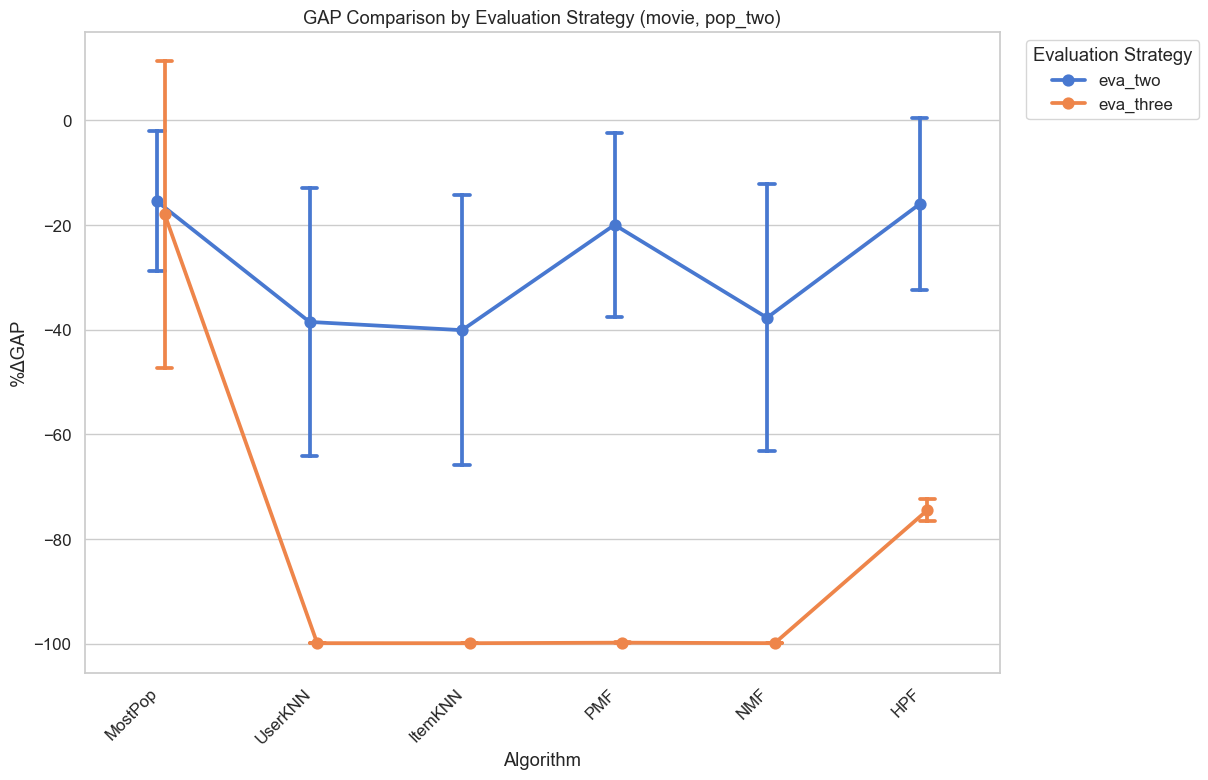

Saved plot: mitigated_results03/analysis_figures/NDCG_eva_comparison_movie_pop_two.png


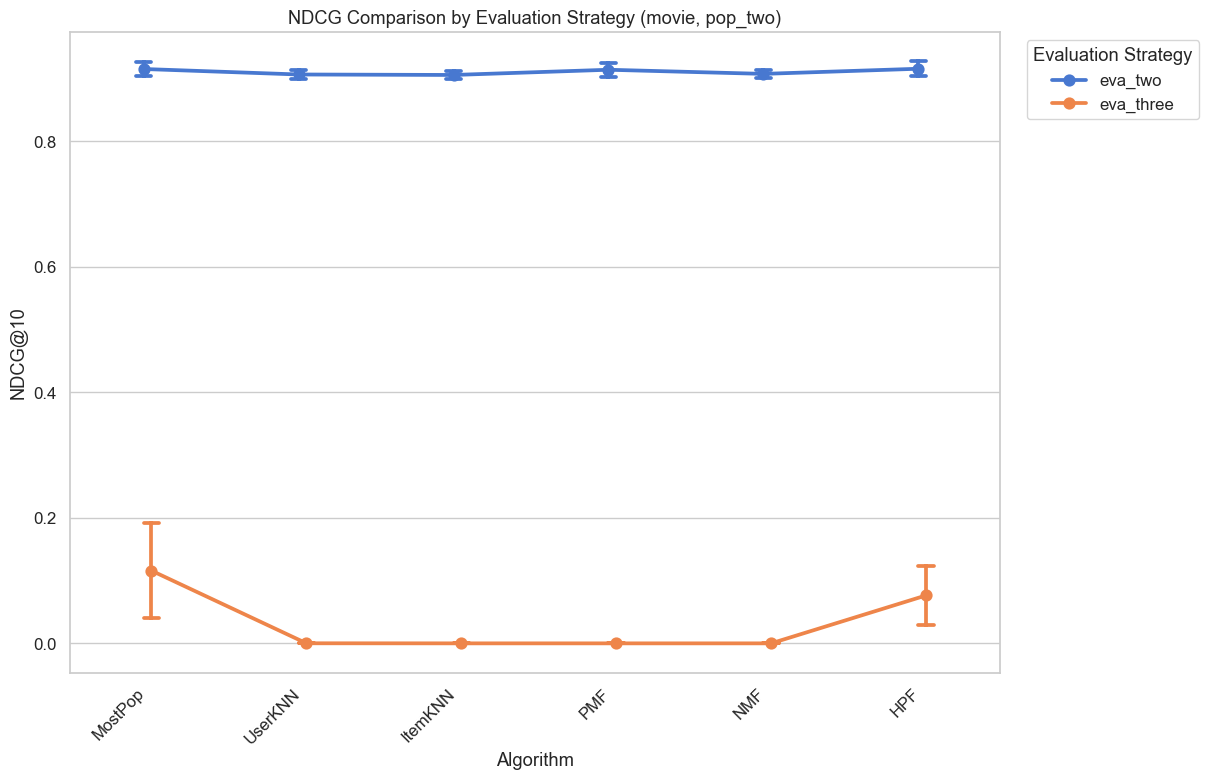

Saved plot: mitigated_results03/analysis_figures/GAP_eva_comparison_movie_pop_four.png


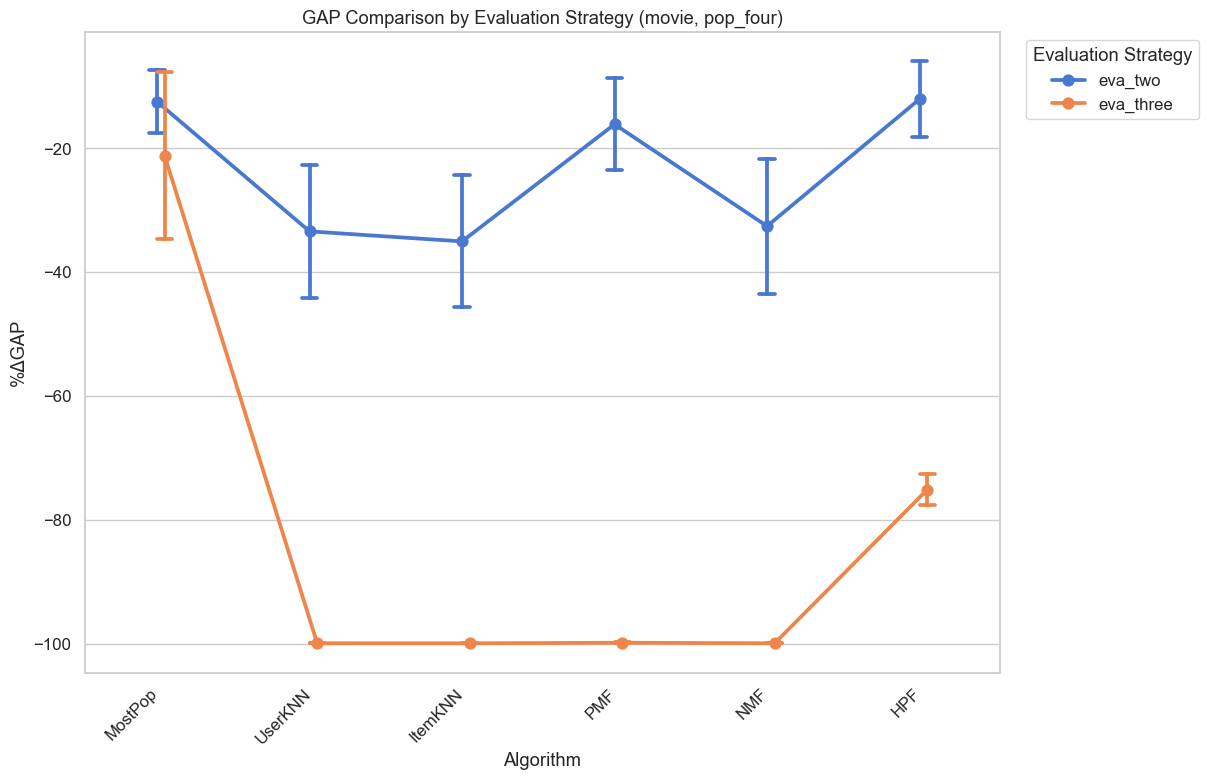

Saved plot: mitigated_results03/analysis_figures/NDCG_eva_comparison_movie_pop_four.png


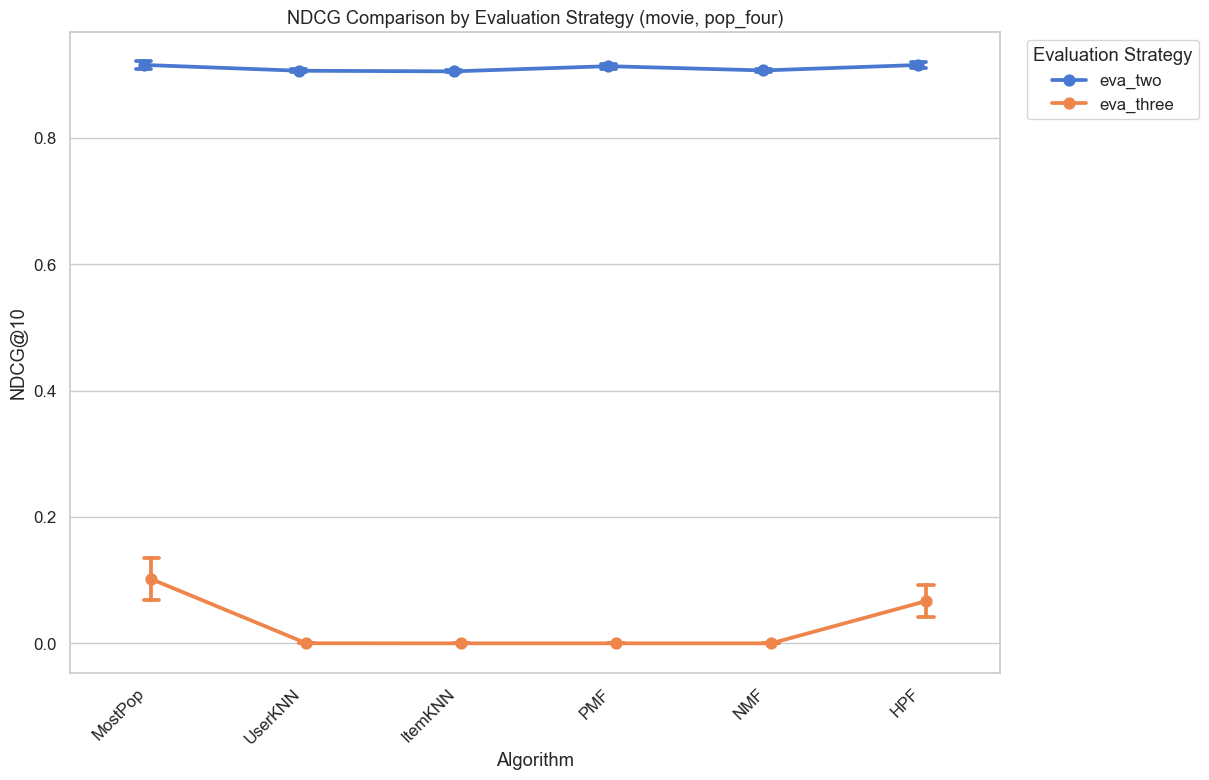

Saved plot: mitigated_results03/analysis_figures/GAP_pop_comparison_low_music_eva_two.png


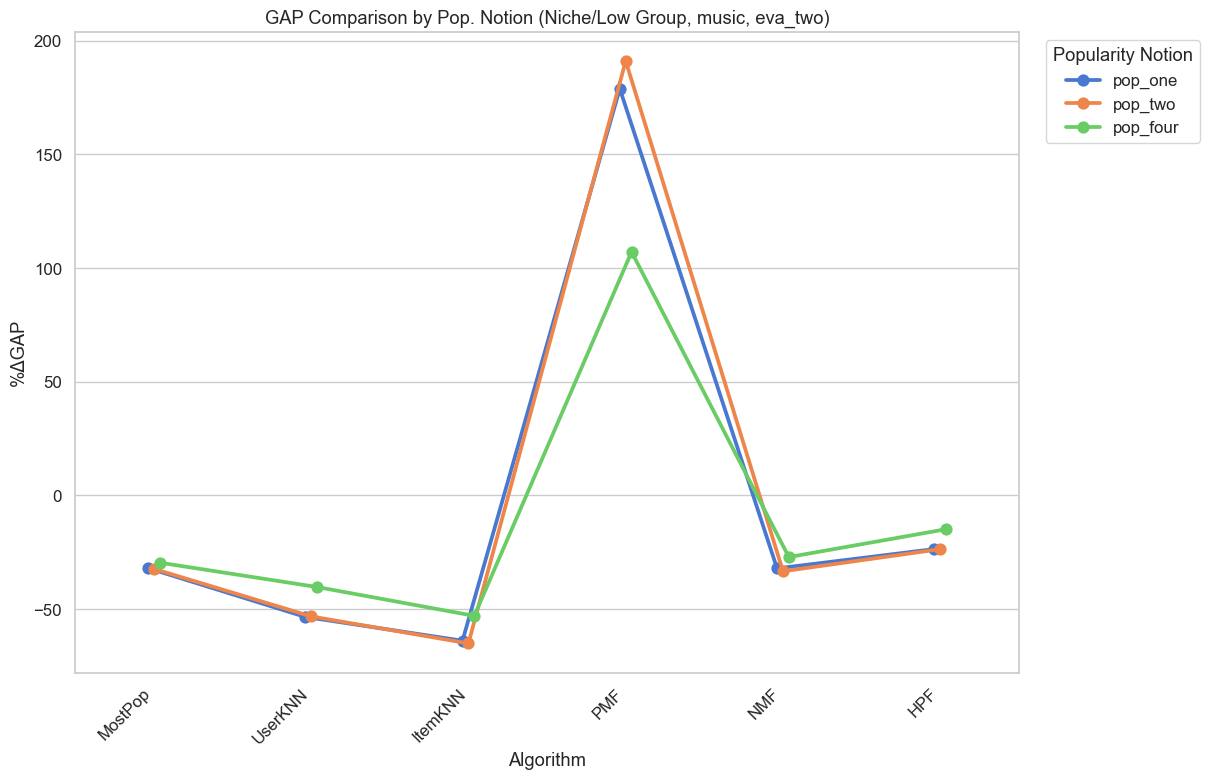

Saved plot: mitigated_results03/analysis_figures/NDCG_pop_comparison_low_music_eva_two.png


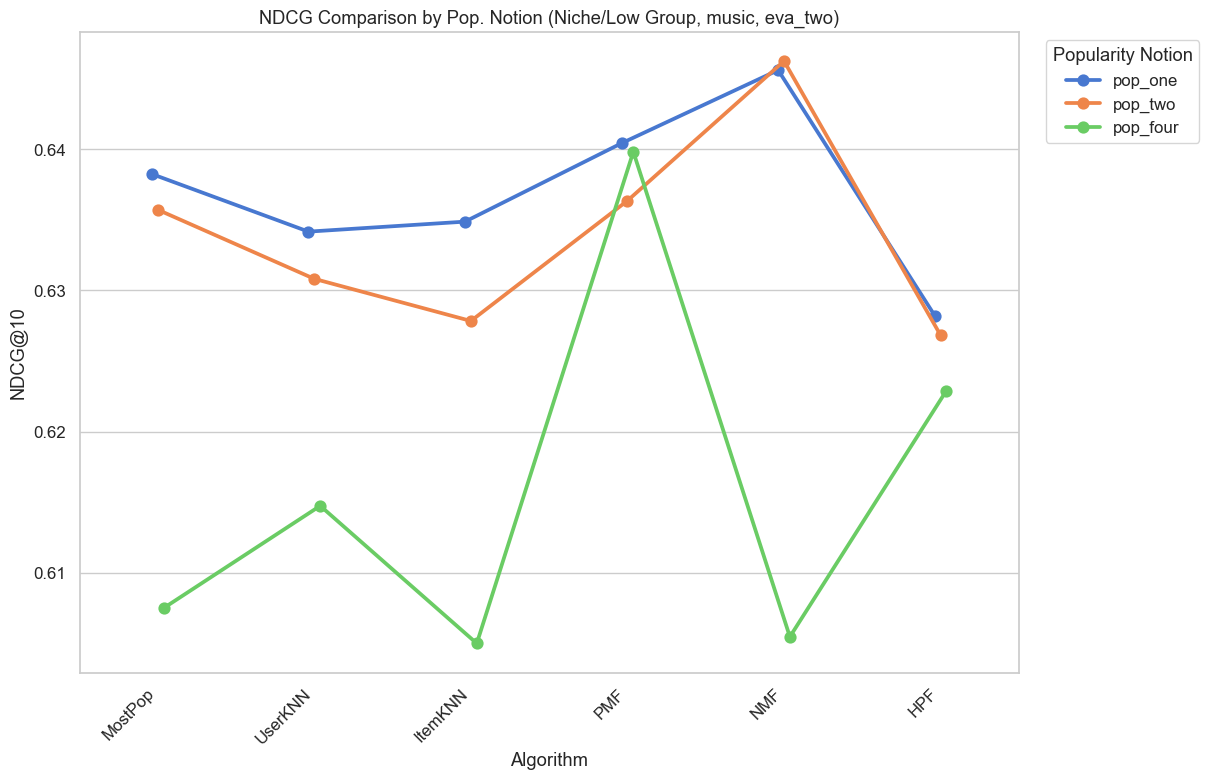

Saved plot: mitigated_results03/analysis_figures/GAP_pop_comparison_low_music_eva_three.png


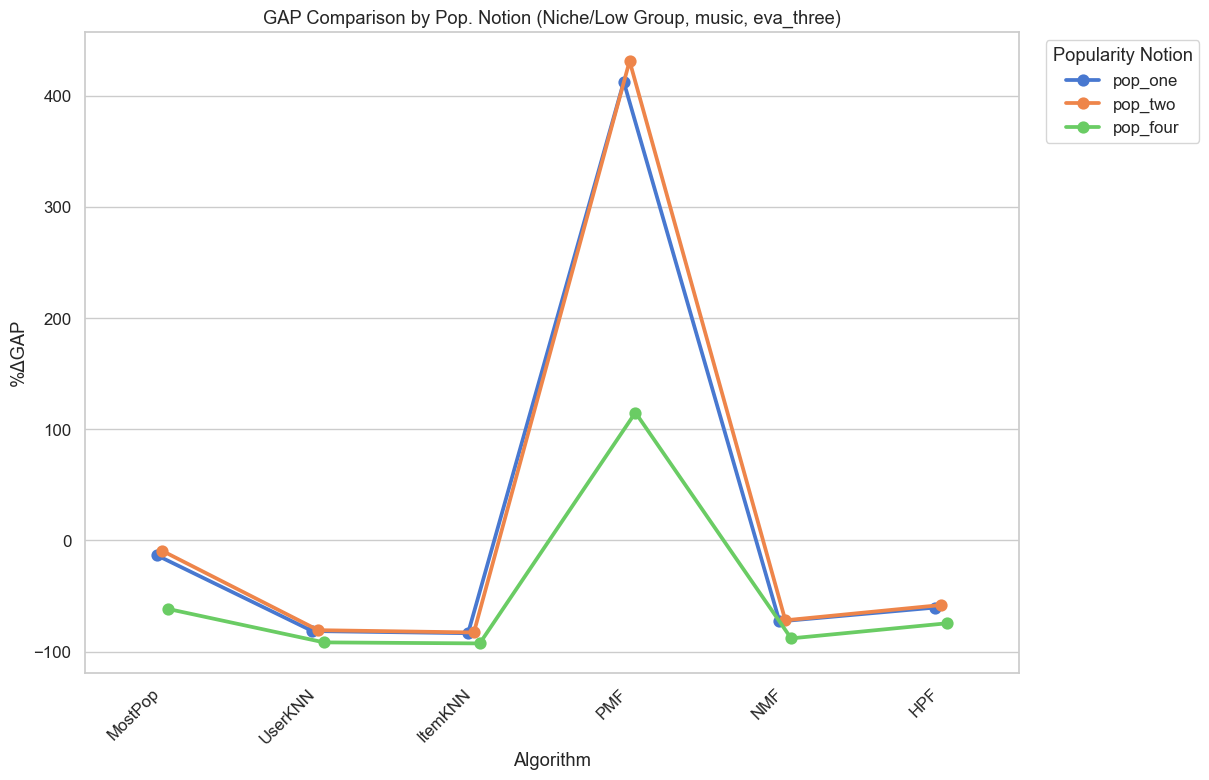

Saved plot: mitigated_results03/analysis_figures/NDCG_pop_comparison_low_music_eva_three.png


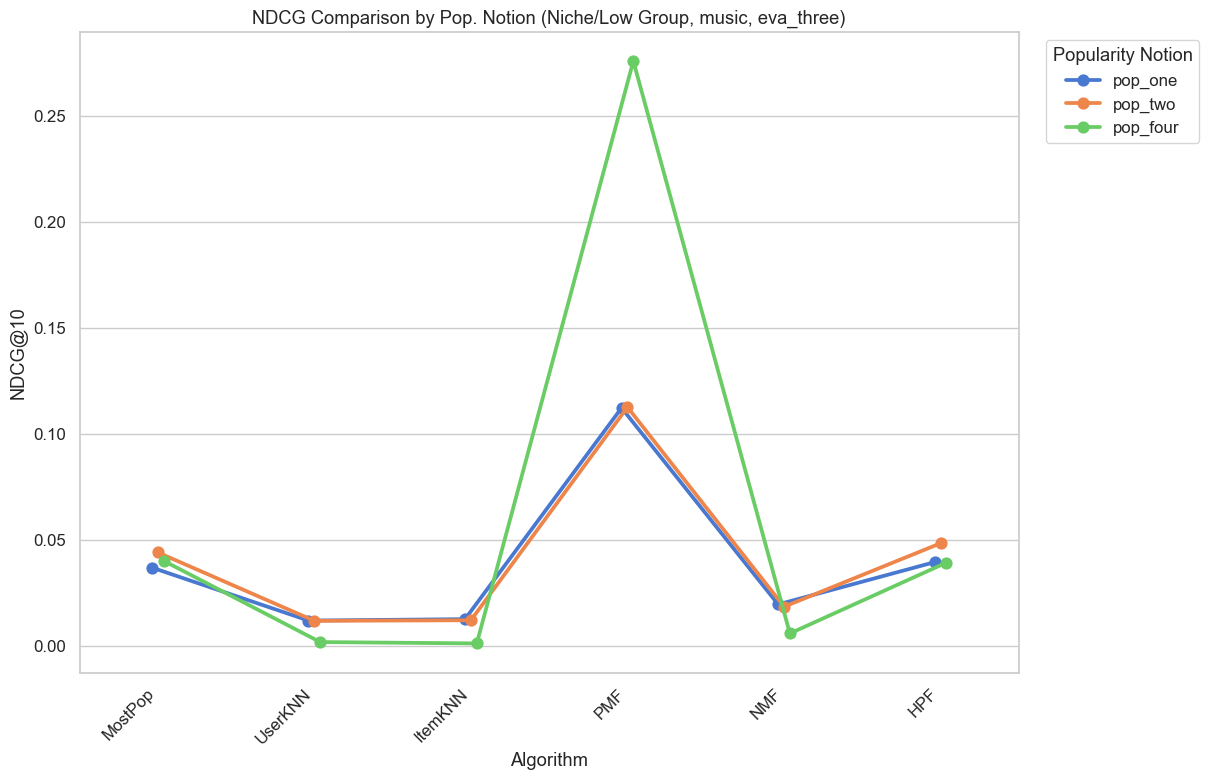

Saved plot: mitigated_results03/analysis_figures/GAP_pop_comparison_low_movie_eva_two.png


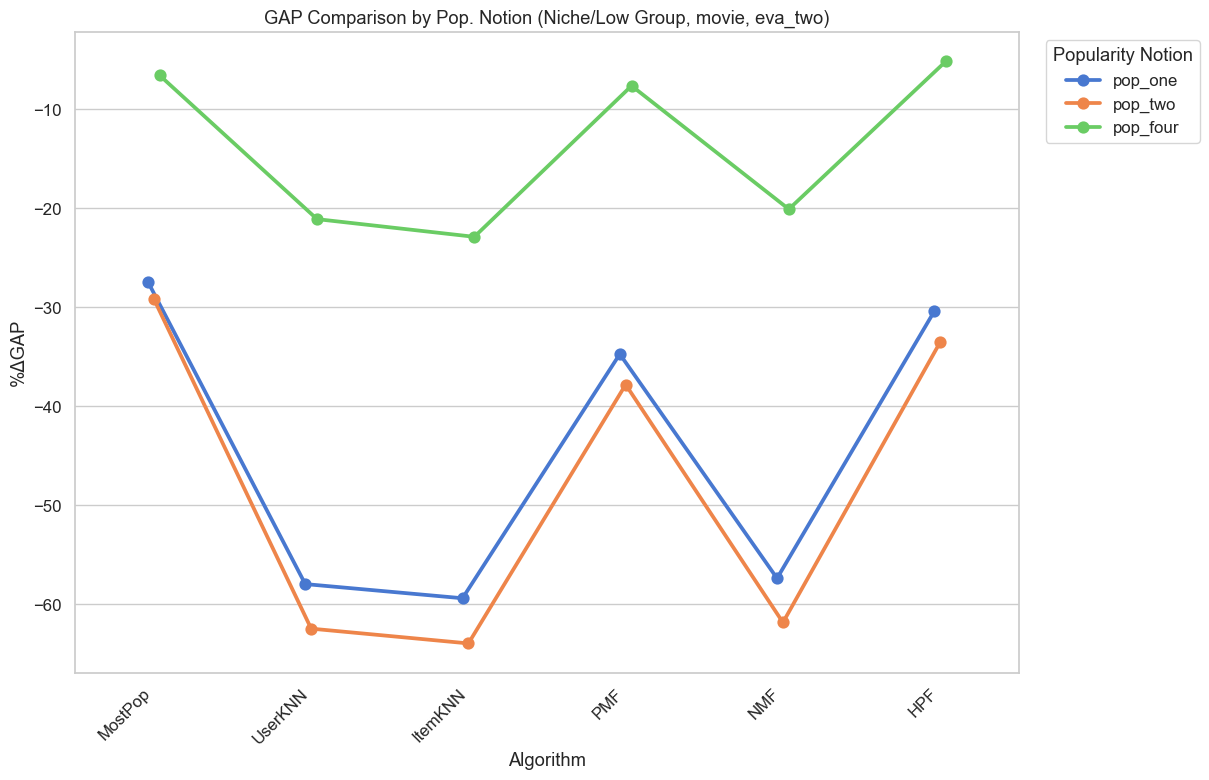

Saved plot: mitigated_results03/analysis_figures/NDCG_pop_comparison_low_movie_eva_two.png


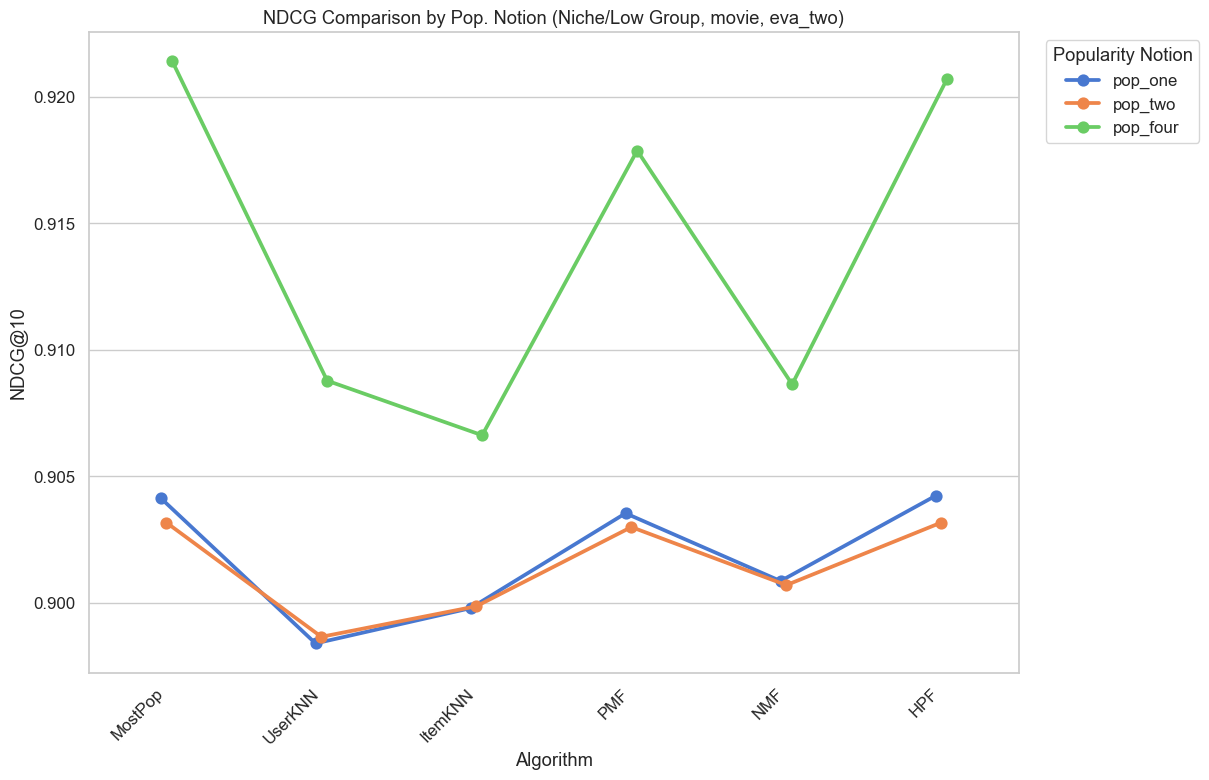

Saved plot: mitigated_results03/analysis_figures/GAP_pop_comparison_low_movie_eva_three.png


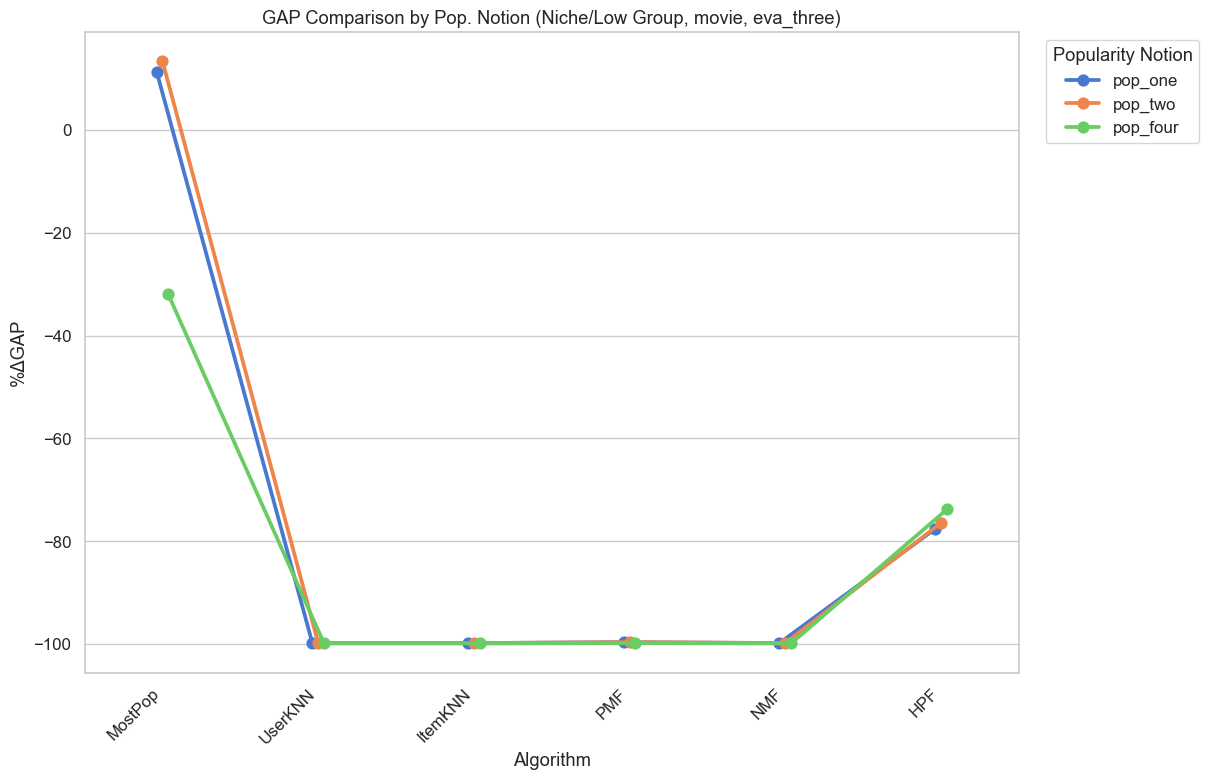

Saved plot: mitigated_results03/analysis_figures/NDCG_pop_comparison_low_movie_eva_three.png


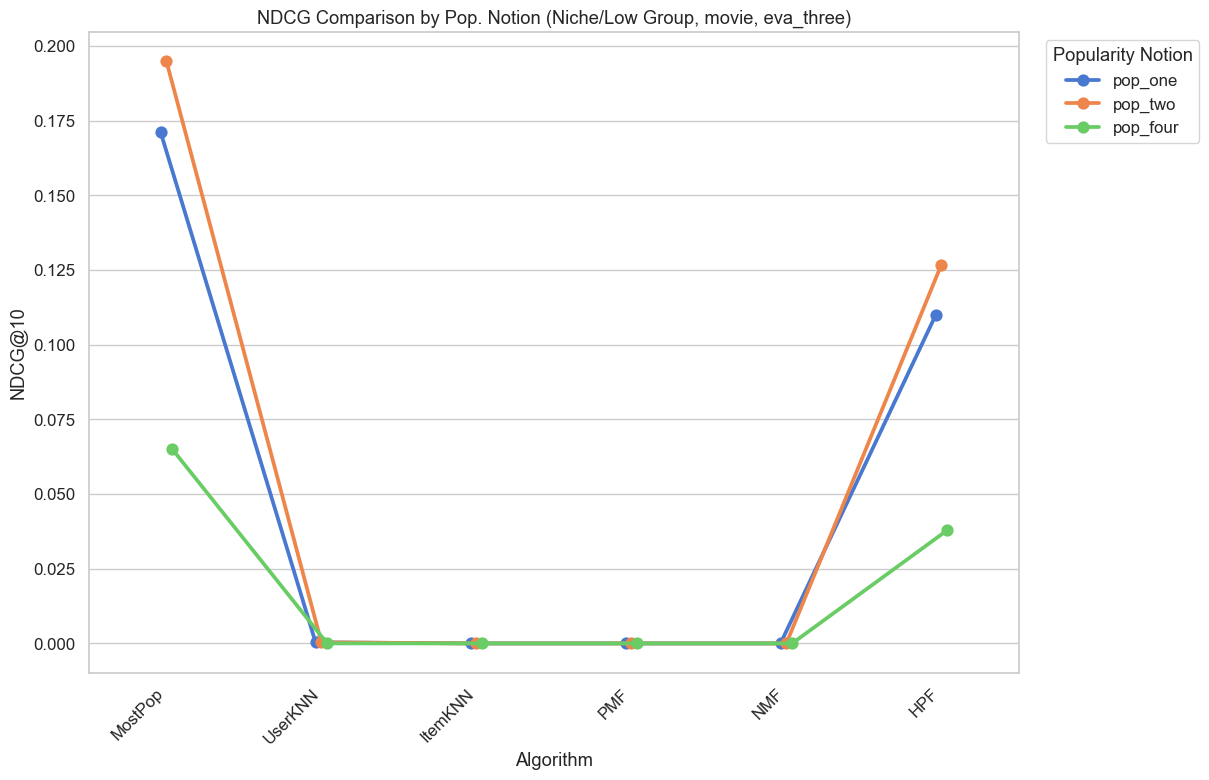

Saved plot: mitigated_results03/analysis_figures/GAP_domain_comparison_low_eva_two_pop_one.png


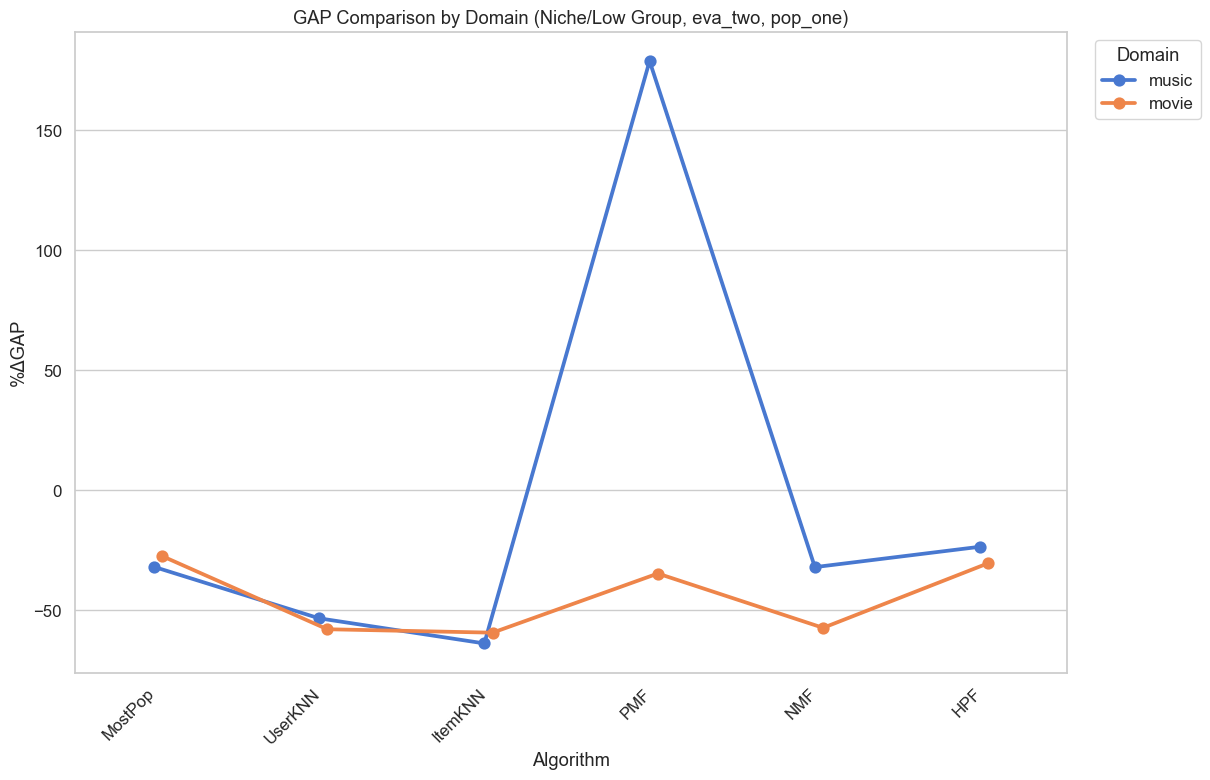

Saved plot: mitigated_results03/analysis_figures/NDCG_domain_comparison_low_eva_two_pop_one.png


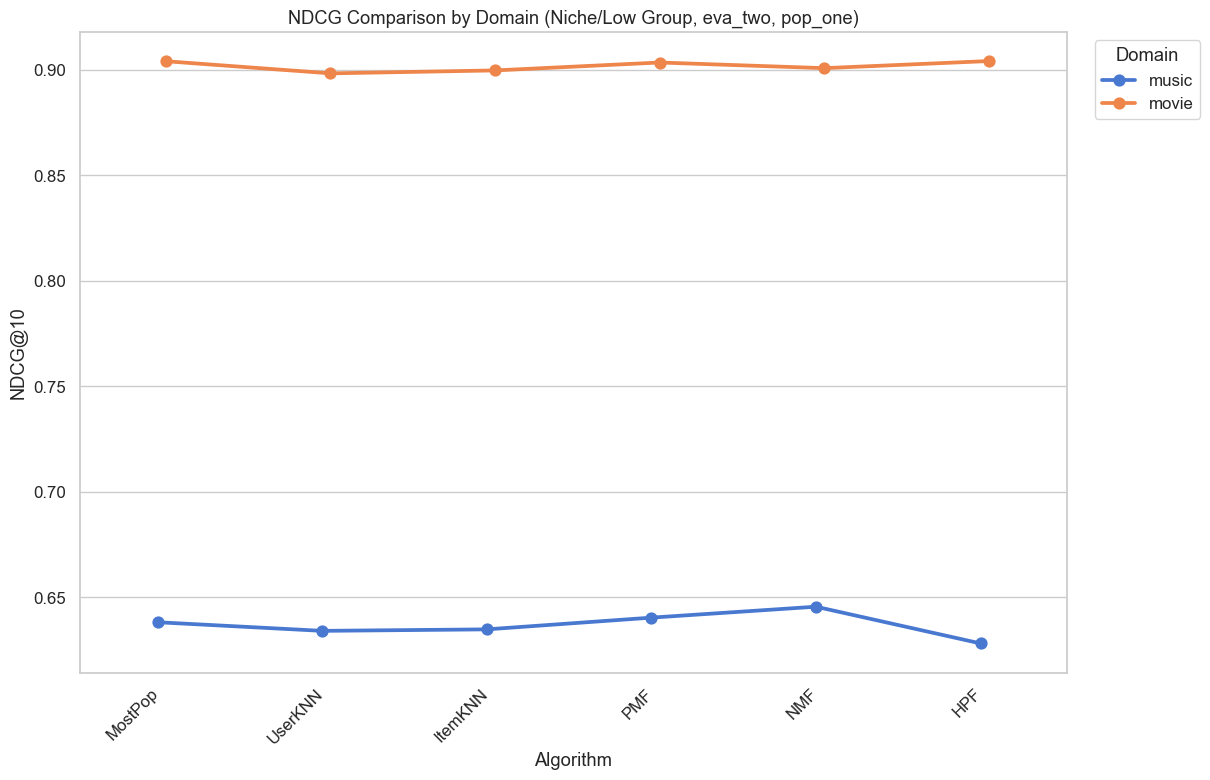

Saved plot: mitigated_results03/analysis_figures/GAP_domain_comparison_low_eva_two_pop_two.png


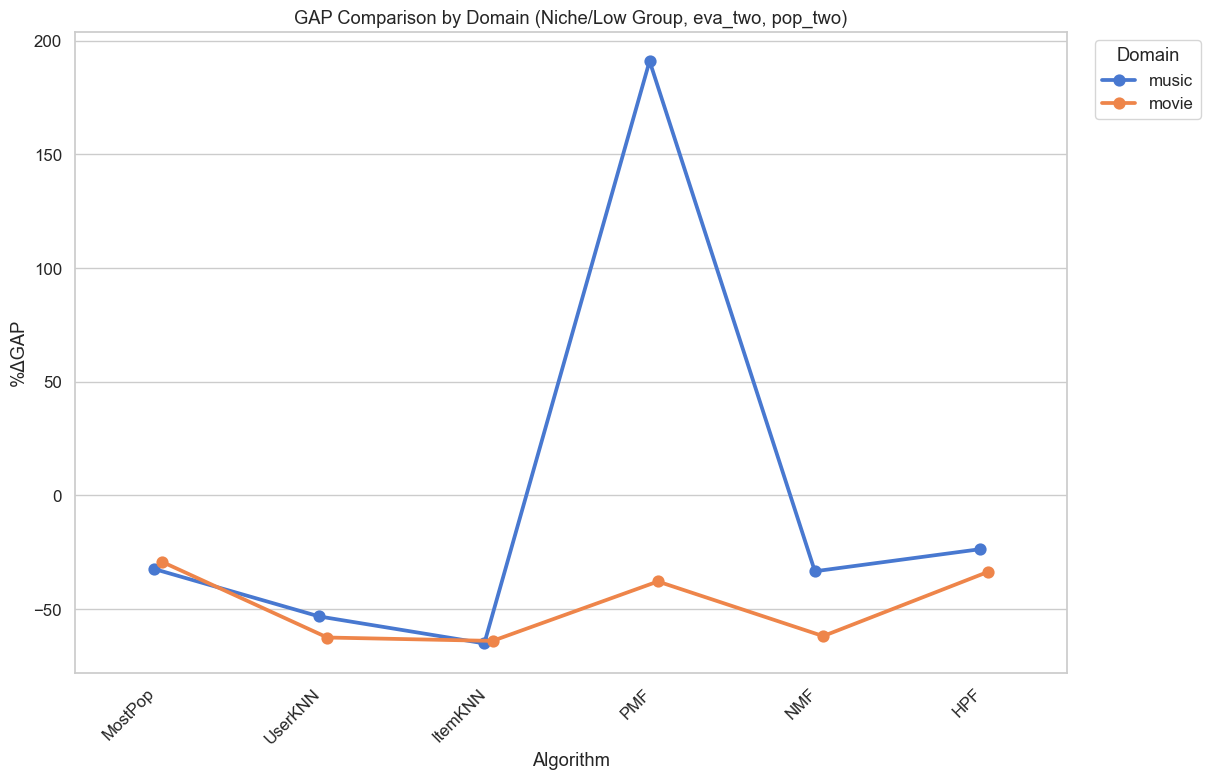

Saved plot: mitigated_results03/analysis_figures/NDCG_domain_comparison_low_eva_two_pop_two.png


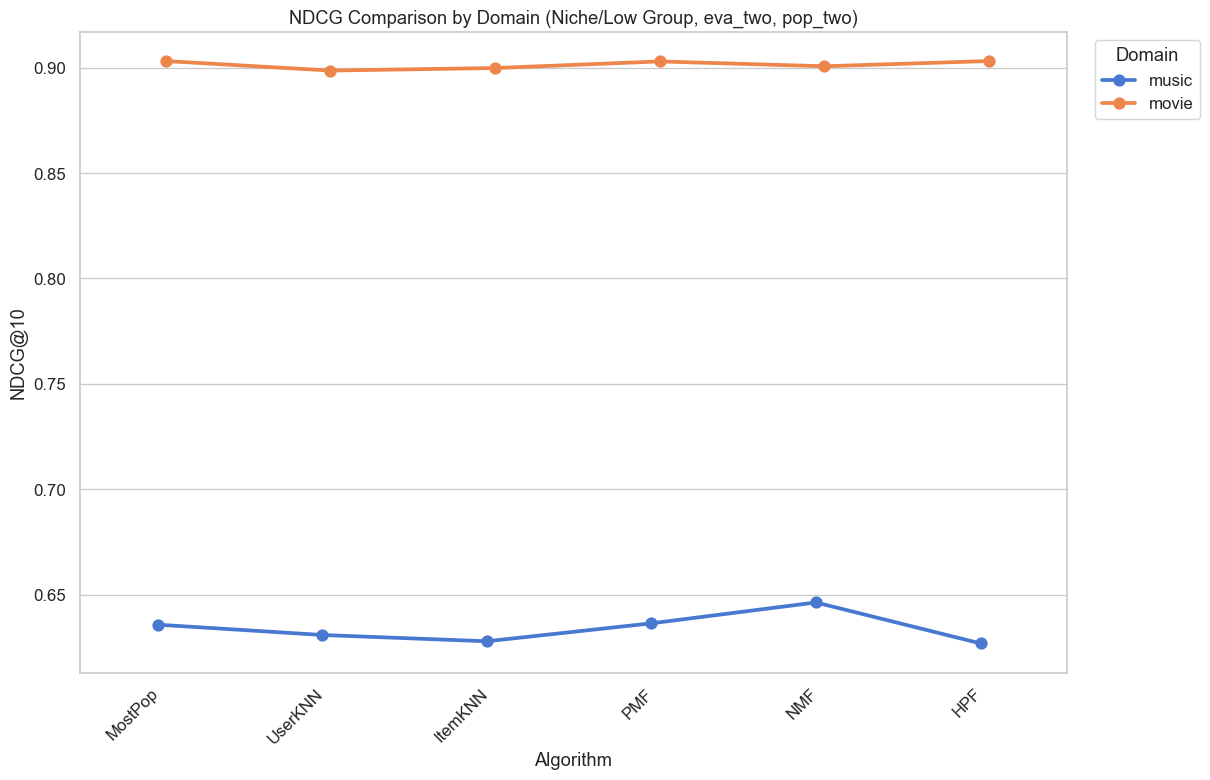

Saved plot: mitigated_results03/analysis_figures/GAP_domain_comparison_low_eva_two_pop_four.png


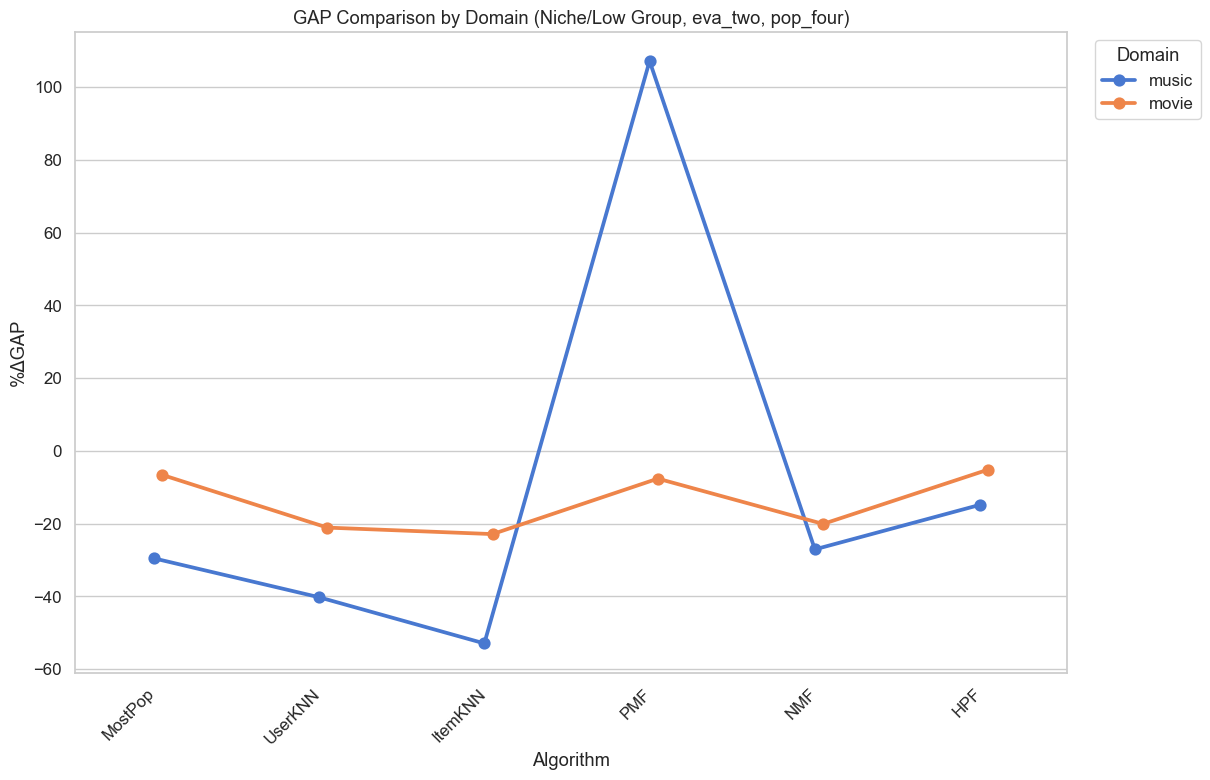

Saved plot: mitigated_results03/analysis_figures/NDCG_domain_comparison_low_eva_two_pop_four.png


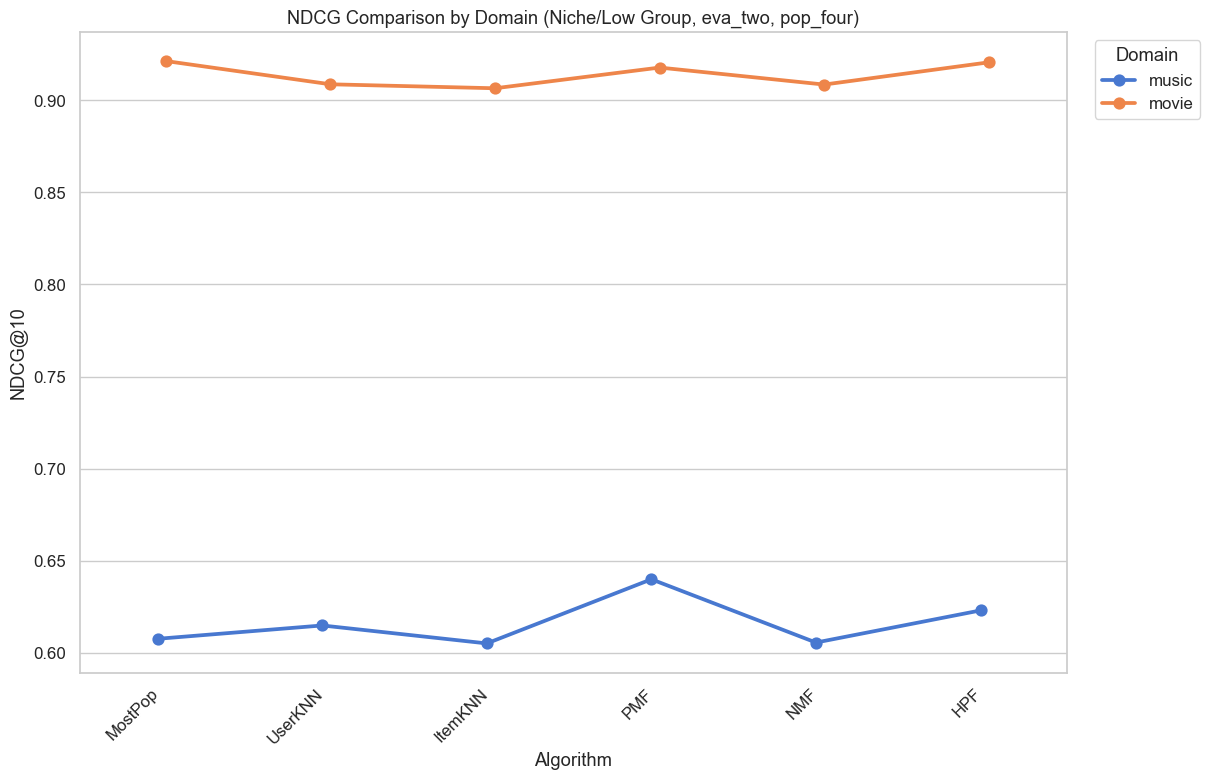

Saved plot: mitigated_results03/analysis_figures/GAP_domain_comparison_low_eva_three_pop_one.png


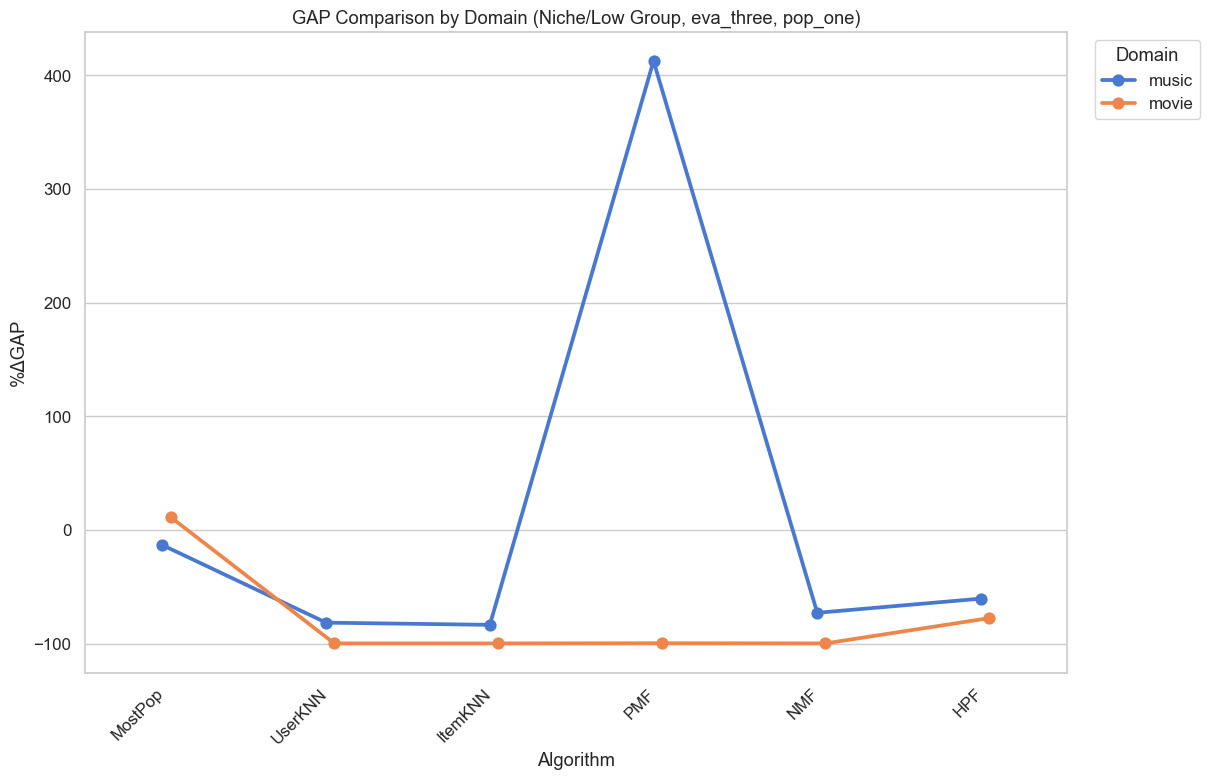

Saved plot: mitigated_results03/analysis_figures/NDCG_domain_comparison_low_eva_three_pop_one.png


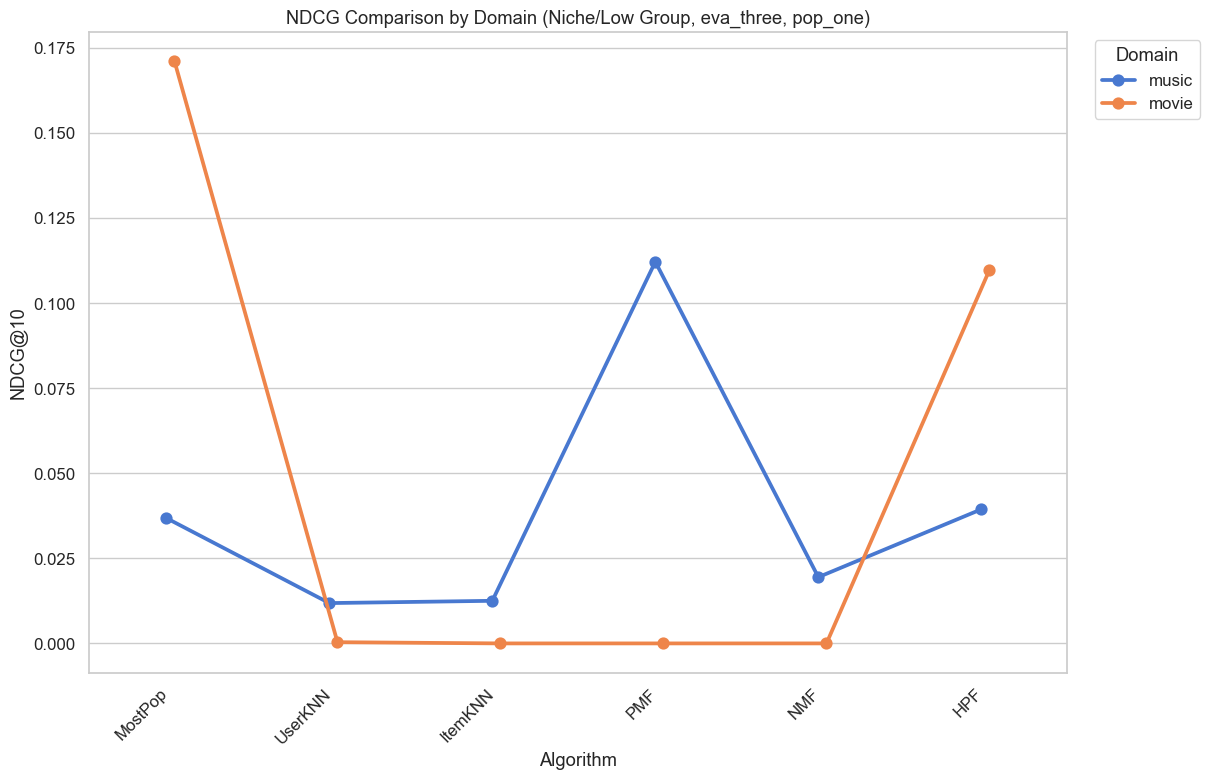

Saved plot: mitigated_results03/analysis_figures/GAP_domain_comparison_low_eva_three_pop_two.png


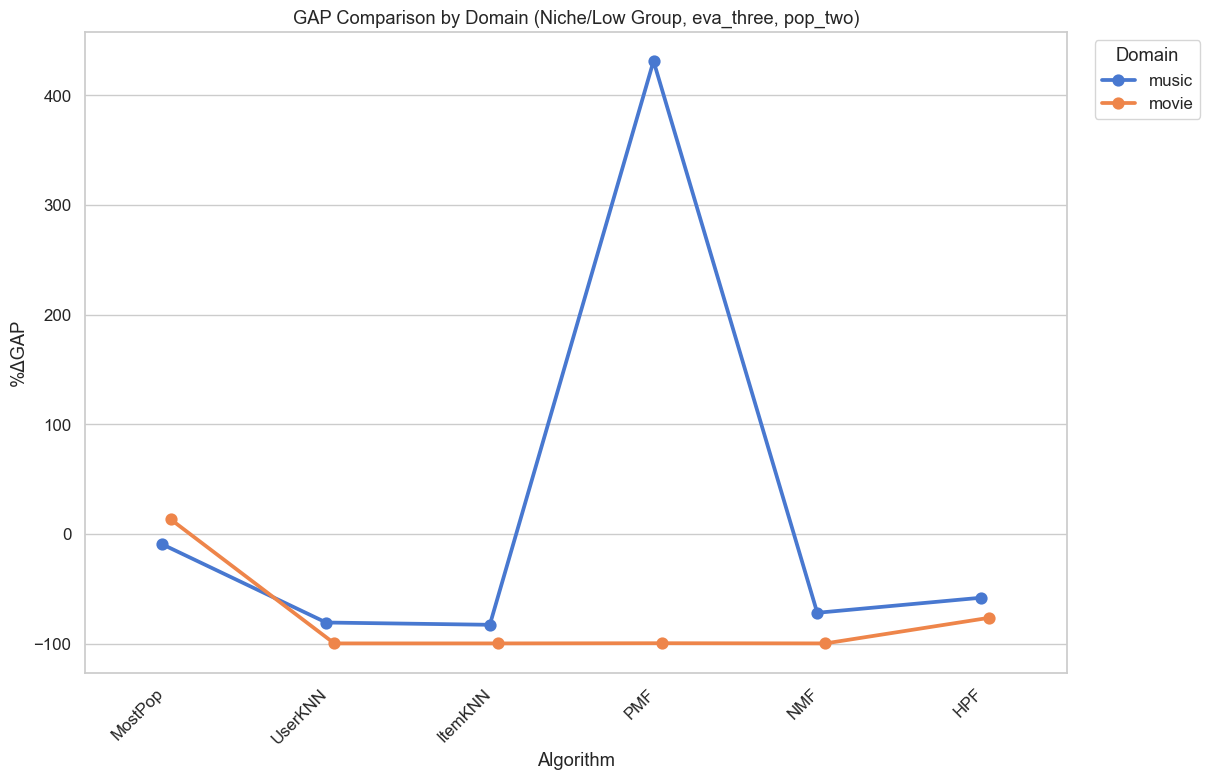

Saved plot: mitigated_results03/analysis_figures/NDCG_domain_comparison_low_eva_three_pop_two.png


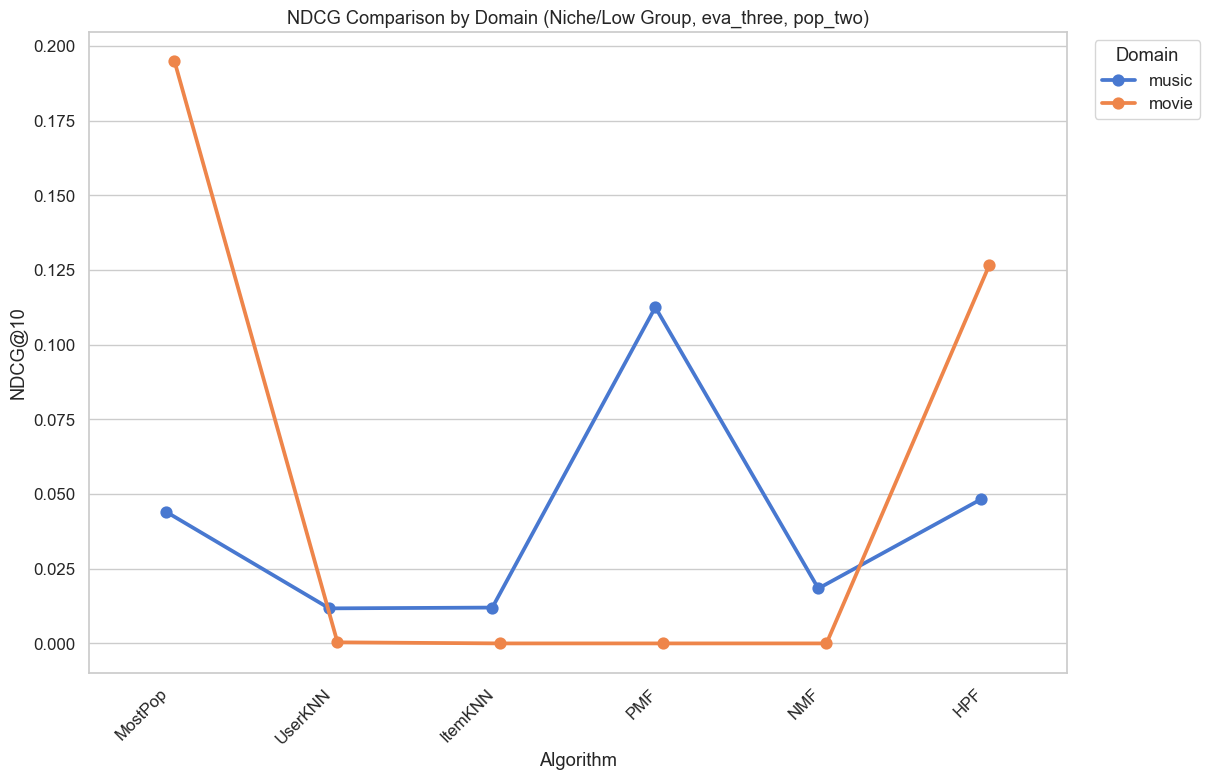

Saved plot: mitigated_results03/analysis_figures/GAP_domain_comparison_low_eva_three_pop_four.png


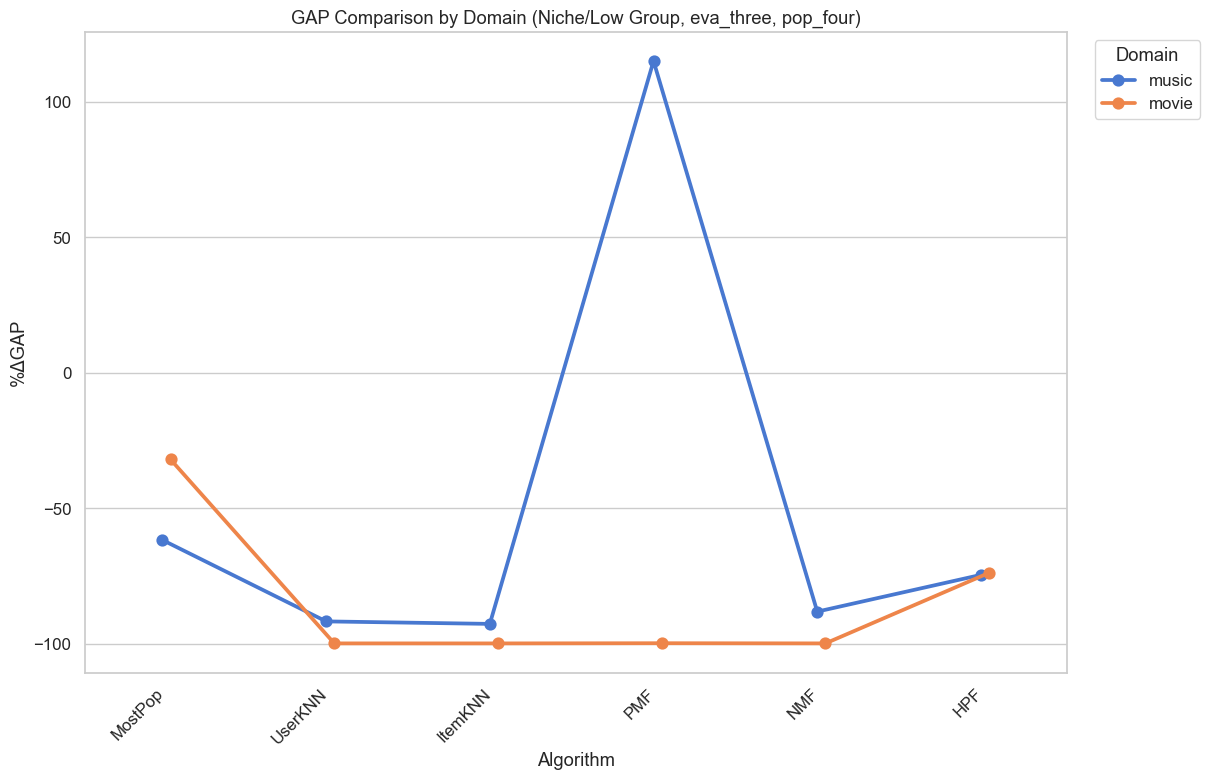

Saved plot: mitigated_results03/analysis_figures/NDCG_domain_comparison_low_eva_three_pop_four.png


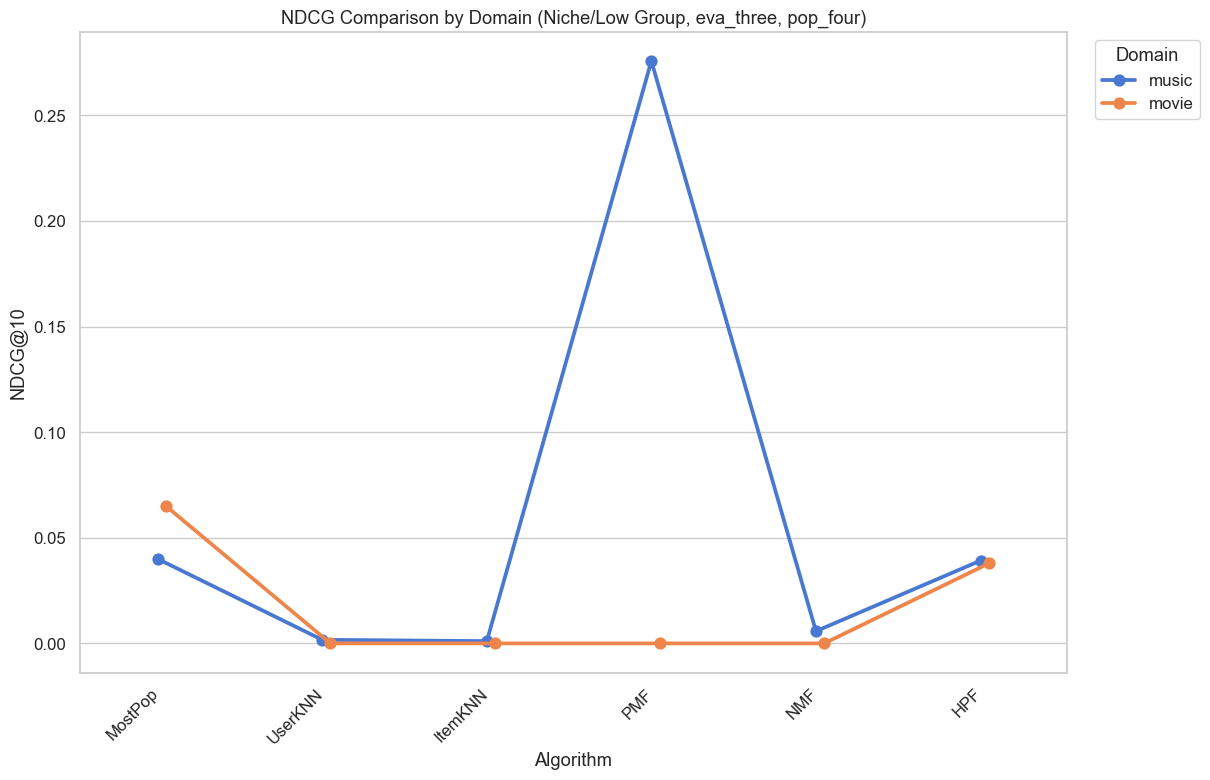

In [6]:
def plot_comparison(df, x_axis, hue_axis, metric, title, filename):
    """Generates a comparison plot (e.g., pointplot or barplot)."""
    if df.empty:
        print(f"Skipping plot '{title}': No data.")
        return
        
    plt.figure(figsize=(14, 8))
    # Ensure consistent algorithm order for x-axis
    algo_order = [algo for algo in ALGORITHMS if algo in df[x_axis].unique()]
    
    # Using pointplot to show trends and confidence intervals (if enough data)
    try:
        ax = sns.pointplot(data=df, x=x_axis, y='value', hue=hue_axis, 
                         order=algo_order if x_axis=='algorithm' else None,
                         dodge=True, errorbar='sd', capsize=.1)
        plt.title(title)
        plt.xlabel(x_axis.replace('_', ' ').title())
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=hue_axis.replace('_', ' ').title(), bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.88, 1])
        
        filepath = os.path.join(FIGURES_DIR, filename)
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Saved plot: {filepath}")
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error plotting '{title}': {e}")
        plt.close()

if not df_consolidated.empty:
    # --- Compare Evaluation Strategies --- 
    df_metrics_only = df_consolidated[df_consolidated['metric_type'].isin(['GAP', 'NDCG'])].copy()
    df_metrics_only['User Group'] = df_metrics_only['user_group'].map(USER_GROUP_NAMES)
    
    for domain in df_metrics_only['domain'].unique():
        for pop in df_metrics_only[df_metrics_only['domain'] == domain]['popularity_notion'].unique():
             for metric_type in ['GAP', 'NDCG']:
                 subset = df_metrics_only[
                     (df_metrics_only['domain'] == domain) & 
                     (df_metrics_only['popularity_notion'] == pop) & 
                     (df_metrics_only['metric_type'] == metric_type)
                 ]
                 plot_comparison(
                     df=subset, 
                     x_axis='algorithm', 
                     hue_axis='evaluation_strategy', 
                     metric='%ΔGAP' if metric_type == 'GAP' else 'NDCG@10',
                     title=f'{metric_type} Comparison by Evaluation Strategy ({domain}, {pop})',
                     filename=f'{metric_type}_eva_comparison_{domain}_{pop}.png'
                 )
                 
    # --- Compare Popularity Notions (within a domain and eva_strategy) ---
    for domain in df_metrics_only['domain'].unique():
        for eva in df_metrics_only[df_metrics_only['domain'] == domain]['evaluation_strategy'].unique():
             for metric_type in ['GAP', 'NDCG']:
                 subset = df_metrics_only[
                     (df_metrics_only['domain'] == domain) & 
                     (df_metrics_only['evaluation_strategy'] == eva) & 
                     (df_metrics_only['metric_type'] == metric_type)
                 ]
                 # Focus on a specific user group, e.g., Niche/Low
                 subset_low = subset[subset['user_group'] == 'low']
                 plot_comparison(
                     df=subset_low, 
                     x_axis='algorithm', 
                     hue_axis='popularity_notion', 
                     metric='%ΔGAP' if metric_type == 'GAP' else 'NDCG@10',
                     title=f'{metric_type} Comparison by Pop. Notion (Niche/Low Group, {domain}, {eva})',
                     filename=f'{metric_type}_pop_comparison_low_{domain}_{eva}.png'
                 )
                 
    # --- Compare Domains (within specific eva and pop) ---
    for eva in df_metrics_only['evaluation_strategy'].unique():
        for pop in df_metrics_only[df_metrics_only['evaluation_strategy'] == eva]['popularity_notion'].unique():
            # Skip pop_three as it's not in movie
            if pop == 'pop_three': continue 
            for metric_type in ['GAP', 'NDCG']:
                 subset = df_metrics_only[
                     (df_metrics_only['evaluation_strategy'] == eva) & 
                     (df_metrics_only['popularity_notion'] == pop) & 
                     (df_metrics_only['metric_type'] == metric_type)
                 ]
                 # Focus on a specific user group, e.g., Niche/Low
                 subset_low = subset[subset['user_group'] == 'low']
                 plot_comparison(
                     df=subset_low, 
                     x_axis='algorithm', 
                     hue_axis='domain', 
                     metric='%ΔGAP' if metric_type == 'GAP' else 'NDCG@10',
                     title=f'{metric_type} Comparison by Domain (Niche/Low Group, {eva}, {pop})',
                     filename=f'{metric_type}_domain_comparison_low_{eva}_{pop}.png'
                 )
else:
    print("Consolidated DataFrame is empty. Cannot perform cross-cutting comparisons.")

## 5. Summary and Conclusions (Excluding MF)

*   **Evaluation Strategy Impact:** Observe the plots comparing `eva_two` and `eva_three`. Does the choice of evaluation strategy significantly change the measured %ΔGAP or NDCG@10 for different algorithms and user groups? As suggested by the paper, `eva_two` (UserTest) often shows different patterns (e.g., potentially less pronounced unfairness in %ΔGAP) compared to `eva_three` (TrainItems), which might better reflect propagation into unseen items.
*   **User Group Fairness (%ΔGAP):** Examine the %ΔGAP plots grouped by user type. Do Niche/Low users consistently show higher %ΔGAP values (indicating recommendations are more biased towards popular items compared to their profiles) than Blockbuster/High users? Does this hold across domains, evaluation strategies, and algorithms like BPR, HPF, NeuMF (if run), VAECF (if run)? How does the exclusion of MF affect this observation?
*   **User Group Performance (NDCG@10):** Look at the NDCG@10 plots. Do Niche/Low users consistently receive lower NDCG scores than other groups? Is this effect stronger for algorithms that exhibit high %ΔGAP for the Niche group? How does the exclusion of MF affect this observation?
*   **Popularity Notion Impact:** Compare the results when users are grouped using `pop_one` (fraction), `pop_two` (average popularity/GAP), and `pop_four` (niche rate). Does the definition of "Niche" significantly alter the conclusions about unfairness?
*   **Domain Differences:** Compare results between 'music' and 'movie'. Are the patterns of bias propagation and fairness similar or different across the two media types?
*   **Algorithm Behavior:** Identify algorithms (excluding MF) that consistently show high %ΔGAP, especially for Niche users. Do these algorithms also show significant differences in NDCG across user groups? Are there algorithms that show less bias according to %ΔGAP?

*(Populate this section with specific observations based on the generated plots and tables, noting the exclusion of MF)*